#  Bike Fleet Intelligence: Pattern Mining, User Clustering \& Predictive Analytics for Bike Sharing

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error


## 2. Data Loading

In [2]:
import os

CSV_URL = "https://pub-c5da5968baf1476f998733ecc980092f.r2.dev/Trips_2018.csv"
CSV_FILE = "Trips_2018.csv"

if not os.path.exists(CSV_FILE):
    print(f"Downloading {CSV_FILE} from {CSV_URL}...")
    import requests
    
    response = requests.get(CSV_URL, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    print(f"File size: {total_size / 1024 / 1024:.2f} MB")
    
    with open(CSV_FILE, 'wb') as f:
        downloaded = 0
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                downloaded += len(chunk)
                if total_size:
                    progress = (downloaded / total_size) * 100
                    print(f"Progress: {progress:.1f}%", end='\r')
    
    print(f"\nDownload complete")
else:
    print(f" {CSV_FILE} already exists locally")

#load the CSV
df = pd.read_csv(CSV_FILE)

#Remove unwanted index column if it exists
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
df["stoptime"]  = pd.to_datetime(df.get("stoptime"), errors="coerce")


#creating a new column start_hour
df["start_hour"] = df["starttime"].dt.floor("h")

#Compute trip duration in minutes
df["trip_duration_min"] = (
    df["tripduration"]/60.0
    if "tripduration" in df.columns
    else (df["stoptime"] - df["starttime"]).dt.total_seconds()/60
)

#Find a representative latitude and longitude for weather data Using median coordinates of all start stations
LAT, LON = df["start_station_latitude"].median(), df["start_station_longitude"].median()

#find the overall date range of the dataset for API query
START = df["start_hour"].min().date().isoformat()
END   = df["start_hour"].max().date().isoformat()

print(f"Trips: {len(df)}  |  Date span: {START} to {END}")
df.head()


 Trips_2018.csv already exists locally
Trips: 17548339  |  Date span: 2018-01-01 to 2018-12-31


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0           505.0             40.749013             -73.988484   31956   
1          3255.0             40.750585             -73.994685   32536   
2           525.0             40.755942             -74.002116   16069   
3           447.0             40.763707             -73.985162   31781   
4          3356.0             40.774667             -73.984706   30319   

     usertype  birth_year  gender          start_hour  trip_duration_min  
0  Subscriber        1992       1 2018-01-01 13:00:00          16.166667  
1  Subscriber        1969       1 2018-01-01 15:00:00          12.050000  
2  Subscriber        1956       1 2018-01-01 15:00:00           8.266667  
3  Subscriber        1974       1 2018-01-01 15:00:00           5.100000  
4  Subscriber        1992       1 2018-01-01 18:00:00           5.100000

## Data Cleaning: Remove Outliers and Invalid Data

In [3]:
initial_count = len(df)
print(f"\nInitial dataset: {initial_count:,} trips")

#AGE/BIRTH YEAR OUTLIERS
print("\n BIRTH YEAR / AGE CLEANING:")
print(f"  Before: Birth year range: {df['birth_year'].min():.0f} - {df['birth_year'].max():.0f}")

#calculate age
df['age_temp'] = 2018 - df['birth_year']

#define reasonable age range for bike riders (7-90 years old)
MIN_AGE = 7
MAX_AGE = 90
MIN_BIRTH_YEAR = 2018 - MAX_AGE  
MAX_BIRTH_YEAR = 2018 - MIN_AGE 

#filter out invalid ages
age_invalid = df[(df['birth_year'] < MIN_BIRTH_YEAR) | (df['birth_year'] > MAX_BIRTH_YEAR) | (df['birth_year'].isna())]
print(f"   Found {len(age_invalid):,} trips with invalid ages:")
print(f"     - Ages < {MIN_AGE} or > {MAX_AGE} years")
print(f"     - Birth years < {MIN_BIRTH_YEAR} or > {MAX_BIRTH_YEAR}")
print(f"     - Missing birth year values")

df = df[(df['birth_year'] >= MIN_BIRTH_YEAR) & (df['birth_year'] <= MAX_BIRTH_YEAR)]
print(f"   After: Birth year range: {df['birth_year'].min():.0f} - {df['birth_year'].max():.0f}")
print(f"   Removed: {len(age_invalid):,} trips ({len(age_invalid)/initial_count*100:.2f}%)")

#TrIP DURATION OUTLIERS
print("\nTRIP DURATION CLEANING:")
print(f"   Before: Duration range: {df['tripduration'].min():.0f}s - {df['tripduration'].max():.0f}s")
print(f"   Before: Duration range: {df['tripduration'].min()/60:.1f}min - {df['tripduration'].max()/3600:.1f}hrs")

#remove trips that are too short (< 60 seconds  and > 24 hours)
MIN_DURATION = 60 
MAX_DURATION = 24 * 3600

duration_invalid = df[(df['tripduration'] < MIN_DURATION) | (df['tripduration'] > MAX_DURATION)]
print(f"   Found {len(duration_invalid):,} trips with invalid durations:")
print(f"     - Durations < {MIN_DURATION}s (1 min)")
print(f"     - Durations > {MAX_DURATION}s (24 hours)")

df = df[(df['tripduration'] >= MIN_DURATION) & (df['tripduration'] <= MAX_DURATION)]
print(f"   After: Duration range: {df['tripduration'].min():.0f}s - {df['tripduration'].max():.0f}s")
print(f"   After: Duration range: {df['tripduration'].min()/60:.1f}min - {df['tripduration'].max()/3600:.1f}hrs")
print(f"   Removed: {len(duration_invalid):,} trips ({len(duration_invalid)/initial_count*100:.2f}%)")

#MISSING CRITICAL VALUES
print("\n MISSING CRITICAL VALUES:")
missing_before = df[['start_station_id', 'end_station_id', 'usertype']].isna().any(axis=1).sum()
print(f"   Found {missing_before:,} trips with missing station IDs or usertype")

df = df.dropna(subset=['start_station_id', 'end_station_id', 'usertype'])
print(f"   Removed: {missing_before:,} trips")

#SUMMARY
print("\n" + "=" * 70)
print("CLEANING SUMMARY:")
final_count = len(df)
total_removed = initial_count - final_count
print(f"Initial trips:    {initial_count:,}")
print(f"Final trips:      {final_count:,}")
print(f"Total removed:    {total_removed:,} ({total_removed/initial_count*100:.2f}%)")
print(f"Data quality:     {final_count/initial_count*100:.2f}% retained")


df = df.drop(columns=['age_temp'])

print("\n Data cleaning complete!")
df.head()


Initial dataset: 17,548,339 trips

 BIRTH YEAR / AGE CLEANING:
  Before: Birth year range: 1885 - 2002
   Found 13,452 trips with invalid ages:
     - Ages < 7 or > 90 years
     - Birth years < 1928 or > 2011
     - Missing birth year values
   After: Birth year range: 1928 - 2002
   Removed: 13,452 trips (0.08%)

TRIP DURATION CLEANING:
   Before: Duration range: 61s - 19510049s
   Before: Duration range: 1.0min - 5419.5hrs
   Found 4,519 trips with invalid durations:
     - Durations < 60s (1 min)
     - Durations > 86400s (24 hours)
   After: Duration range: 61s - 86385s
   After: Duration range: 1.0min - 24.0hrs
   Removed: 4,519 trips (0.03%)

 MISSING CRITICAL VALUES:
   Found 2,485 trips with missing station IDs or usertype
   Removed: 2,485 trips

CLEANING SUMMARY:
Initial trips:    17,548,339
Final trips:      17,527,883
Total removed:    20,456 (0.12%)
Data quality:     99.88% retained

 Data cleaning complete!


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  \
0           505.0             40.749013             -73.988484   31956   
1          3255.0             40.750585             -73.994685   32536   
2           525.0             40.755942             -74.002116   16069   
3           447.0             40.763707             -73.985162   31781   
4          3356.0             40.774667             -73.984706   30319   

     usertype  birth_year  gender          start_hour  trip_duration_min  
0  Subscriber        1992       1 2018-01-01 13:00:00          16.166667  
1  Subscriber        1969       1 2018-01-01 15:00:00          12.050000  
2  Subscriber        1956       1 2018-01-01 15:00:00           8.266667  
3  Subscriber        1974       1 2018-01-01 15:00:00           5.100000  
4  Subscriber        1992       1 2018-01-01 18:00:00           5.100000

## 4. Weather Data Integration

In [4]:
stations = df[["start_station_id", "start_station_latitude", "start_station_longitude"]].drop_duplicates()

#building a small grid (≈2–3 km)
GRID = 0.03  

stations = stations.copy()
stations["lat_bin"] = (stations["start_station_latitude"]  / GRID).round().astype(int)
stations["lon_bin"] = (stations["start_station_longitude"] / GRID).round().astype(int)
stations["cell_id"] = stations["lat_bin"].astype(str) + "_" + stations["lon_bin"].astype(str)

cells = (stations.groupby("cell_id", as_index=False)
         .agg(lat=("start_station_latitude", "median"),
              lon=("start_station_longitude", "median")))

print(f"Unique grid cells to fetch: {len(cells)}")


def fetch_cell(lat, lon, start_date, end_date, retries=5, pause=1.5):
    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = [
        "temperature_2m","apparent_temperature","rain","snowfall",
        "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
    ]
    params = {
        "latitude": float(lat), "longitude": float(lon),
        "start_date": start_date, "end_date": end_date,
        "timezone": "America/New_York",
        "hourly": ",".join(hourly_vars) 
    }
    last_err = None
    for a in range(retries):
        try:
            resp = requests.get(url, params=params, timeout=40)
            if resp.ok:
                js = resp.json()
                if "hourly" in js:
                    wx = pd.DataFrame(js["hourly"])
                    wx["start_hour"] = pd.to_datetime(wx["time"])
                    wx = wx.drop(columns=["time"])
                    for c in wx.columns:
                        if c != "start_hour" and pd.api.types.is_float_dtype(wx[c]):
                            wx[c] = pd.to_numeric(wx[c], downcast="float")
                    return wx
                else:
                    last_err = f"no 'hourly' in response (keys={list(js.keys())})"
            else:
                last_err = f"HTTP {resp.status_code}: {resp.text[:160]}"
        except Exception as e:
            last_err = str(e)
        time.sleep(pause * (a + 1)) 
    return None

cell_weather, failed_cells = [], []
for _, r in cells.iterrows():
    wx_cell = fetch_cell(r["lat"], r["lon"], START, END)
    if wx_cell is None:
        failed_cells.append(r["cell_id"])
        continue
    wx_cell["cell_id"] = r["cell_id"]
    cell_weather.append(wx_cell)
    time.sleep(0.2) 

if not cell_weather:
    print("All grid cells failed. Falling back to city-median weather…")
    lat0 = float(df["start_station_latitude"].median())
    lon0 = float(df["start_station_longitude"].median())
    wx_city = fetch_cell(lat0, lon0, START, END)
    if wx_city is None:
        raise RuntimeError(
            f"No weather fetched even for city median. Check network/date range. START={START}, END={END}"
        )
    wx_city["cell_id"] = "city_median"
    wx_cells = wx_city.copy()
    stations2 = stations.copy()
    stations2["use_cell"] = "city_median"
else:
    wx_cells = pd.concat(cell_weather, ignore_index=True)
    print(f"Weather rows (cells): {len(wx_cells)} | cells covered: {wx_cells['cell_id'].nunique()}")

    # If some cells failed, borrow weather from nearest fetched cell
    if failed_cells:
        print("Filling missing cells from nearest fetched cell…")

        have = cells[cells["cell_id"].isin(wx_cells["cell_id"].unique())].copy()
        need = cells[cells["cell_id"].isin(failed_cells)].copy()

        def haversine(lat1, lon1, lat2, lon2):
            R = 6371.0
            lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return 2 * R * np.arcsin(np.sqrt(a))

        alias_rows = []
        H_lat = have["lat"].to_numpy()
        H_lon = have["lon"].to_numpy()
        for _, r in need.iterrows():
            d = haversine(r["lat"], r["lon"], H_lat, H_lon)
            nearest = have.iloc[d.argmin()]["cell_id"]
            alias_rows.append((r["cell_id"], nearest))
        alias = pd.DataFrame(alias_rows, columns=["cell_id", "use_cell"])
    else:
        alias = pd.DataFrame(columns=["cell_id", "use_cell"])

    stations2 = stations.merge(alias, on="cell_id", how="left")
    stations2["use_cell"] = stations2["use_cell"].fillna(stations2["cell_id"])

wx = (stations2[["start_station_id", "use_cell"]]
      .rename(columns={"use_cell": "cell_id"})
      .merge(wx_cells, on="cell_id", how="left"))

print("Total weather rows (expanded to stations):", len(wx))


Unique grid cells to fetch: 23
Weather rows (cells): 201480 | cells covered: 23
Total weather rows (expanded to stations): 7174440


In [5]:
weather_hourly = (
    wx_cells
    .groupby("start_hour")[[
        "temperature_2m",
        "rain",
        "snowfall",
        "wind_speed_10m",
        "cloud_cover",
        "visibility"
    ]]
    .mean()
    .reset_index()
    .rename(columns={"start_hour": "hour"})
)

print("Weather_hourly shape:", weather_hourly.shape)
print(weather_hourly.head())


Weather_hourly shape: (8760, 7)
                 hour  temperature_2m  rain  snowfall  wind_speed_10m  \
0 2018-01-01 00:00:00      -13.678261   0.0       0.0       16.373913   
1 2018-01-01 01:00:00      -13.839129   0.0       0.0       16.369566   
2 2018-01-01 02:00:00      -14.060869   0.0       0.0       15.795651   
3 2018-01-01 03:00:00      -14.273912   0.0       0.0       15.334782   
4 2018-01-01 04:00:00      -14.456522   0.0       0.0       15.995652   

   cloud_cover visibility  
0     0.130435        NaN  
1     1.347826        NaN  
2     2.043478        NaN  
3     2.391304        NaN  
4     2.434783        NaN  


## 5. Feature Engineering

In [6]:
#Temperature (°C)
weather_hourly["temp_celsius"] = weather_hourly["temperature_2m"]

#dryness flag
rain  = weather_hourly["rain"].fillna(0)
snow  = weather_hourly["snowfall"].fillna(0)
weather_hourly["is_dry"] = ((rain + snow) == 0).astype("int8")

#wind
weather_hourly["wind_kmh"] = weather_hourly["wind_speed_10m"] * 3.6

#visibility (only if column exists)
if "visibility" in weather_hourly.columns:
    weather_hourly["visibility_km"] = weather_hourly["visibility"] / 1000.0
else:
    weather_hourly["visibility_km"] = np.nan

#cycling score
weather_hourly["cycling_score"] = (
    np.exp(-((weather_hourly["temp_celsius"] - 20) / 10) ** 2) * 40
    + weather_hourly["is_dry"] * 30
    + (weather_hourly["wind_kmh"] < 20).astype("int8") * 20
    + (weather_hourly["visibility_km"] > 5).astype("int8") * 10
).clip(0, 100)

weather_hourly.head()


hour  temperature_2m  rain  snowfall  wind_speed_10m  \
0 2018-01-01 00:00:00      -13.678261   0.0       0.0       16.373913   
1 2018-01-01 01:00:00      -13.839129   0.0       0.0       16.369566   
2 2018-01-01 02:00:00      -14.060869   0.0       0.0       15.795651   
3 2018-01-01 03:00:00      -14.273912   0.0       0.0       15.334782   
4 2018-01-01 04:00:00      -14.456522   0.0       0.0       15.995652   

   cloud_cover visibility  temp_celsius  is_dry   wind_kmh visibility_km  \
0     0.130435        NaN    -13.678261       1  58.946083           NaN   
1     1.347826        NaN    -13.839129       1  58.930435           NaN   
2     2.043478        NaN    -14.060869       1  56.864346           NaN   
3     2.391304        NaN    -14.273912       1  55.205212           NaN   
4     2.434783        NaN    -14.456522       1  57.584347           NaN   

   cycling_score  
0      30.000475  
1      30.000425  
2      30.000366  
3      30.000317  
4      30.000278

In [7]:
# merging trips with hourly weather

is_station_level = "start_station_id" in wx.columns
key_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])

print("Merging on:", key_cols)

wanted_wx = [
    "start_hour", "start_station_id",
    "temperature_2m","apparent_temperature","rain","snowfall",
    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
]
wx_keyed = wx[[c for c in wanted_wx if c in wx.columns]].drop_duplicates(subset=key_cols)

dfm = df.merge(
    wx_keyed,
    on=key_cols,
    how="left",          
    validate="m:1"     
)

# merge quality
miss_pct = dfm["temperature_2m"].isna().mean() * 100
print(f"Merge complete | rows={len(dfm):,} | weather coverage={100 - miss_pct:.1f}%")

dfm.head()

Merging on: ['start_hour', 'start_station_id']
Merge complete | rows=17,527,883 | weather coverage=100.0%


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  ...  \
0           505.0             40.749013             -73.988484   31956  ...   
1          3255.0             40.750585             -73.994685   32536  ...   
2           525.0             40.755942             -74.002116   16069  ...   
3           447.0             40.763707             -73.985162   31781  ...   
4          3356.0             40.774667             -73.984706   30319  ...   

           start_hour  trip_duration_min  temperature_2m apparent_temperature  \
0 2018-01-01 13:00:00          16.166667            -8.1                -14.9   
1 2018-01-01 15:00:00          12.050000            -6.9                -13.7   
2 2018-01-01 15:00:00           8.266667            -6.9                -13.7   
3 2018-01-01 15:00:00           5.100000            -6.9                -13.7   
4 2018-01-01 18:00:00           5.100000           -10.0                -15.0   

   rain  snowfall  wind_speed_10m  relative_humidity_2m  cloud_cover  \
0   0.0       0.0       20.400000                    30            0   
1   0.0       0.0       19.700001                    24           55   
2   0.0       0.0       19.700001                    24           55   
3   0.0       0.0       19.700001                    24           55   
4   0.0       0.0        7.400000                    39           23   

   visibility  
0        None  
1        None  
2        None  
3        None  
4        None  

[5 rows x 23 columns]

### 5.1 Weather Feature Engineering

In [8]:
# Ensure all needed columns exist
need = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]
for c in need:
    if c not in dfm.columns:
        dfm[c] = np.nan
dfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")

# temperature (°C)
dfm["temp_celsius"] = dfm["temperature_2m"]
dfm["temp_category"] = pd.cut(
    dfm["temp_celsius"],
    bins=[-99, 0, 10, 20, 25, 30, 99],
    labels=["freezing","cold","cool","comfortable","warm","hot"]
)

# 2) Dryness (1 dry, 0 wet)
rain  = dfm["rain"].fillna(0)
snow  = dfm["snowfall"].fillna(0)
dfm["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind, sky, visibility
dfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6
dfm["sky_condition"] = pd.cut(
    dfm["cloud_cover"],
    bins=[-1, 25, 50, 75, 100.1],
    labels=["clear","partly_cloudy","cloudy","overcast"]
)
dfm["visibility_km"] = dfm["visibility"] / 1000.0

# cycling score (0–100): Weights proportional to empirical correlation coefficients
# temp r=0.443, is_dry r=0.128 
dfm["cycling_score"] = (
    np.exp(-((dfm["temp_celsius"] - 20) / 10) ** 2) * 69           # temperature comfort peak ~20°C (69%)
    + dfm["is_dry"] * 20                                           # dry bonus (20%)
    + (dfm["wind_kmh"] < 20).astype("int8") * 7                    # calm wind (7%)
    + (dfm["visibility_km"] > 5).astype("int8") * 4                # clear view (4%)
).clip(0, 100)

dfm["temp_category"] = dfm["temp_category"].astype("category")
dfm["sky_condition"]  = dfm["sky_condition"].astype("category")

print(f"Weather features added | shape={dfm.shape} | new cols: "
      f"['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']")
dfm.head()


Weather features added | shape=(17527883, 30) | new cols: ['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']


tripduration               starttime                stoptime  \
0           970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186   
1           723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2           496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3           306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4           306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

   start_station_id  start_station_latitude  start_station_longitude  \
0              72.0               40.767272               -73.993929   
1              72.0               40.767272               -73.993929   
2              72.0               40.767272               -73.993929   
3              72.0               40.767272               -73.993929   
4              72.0               40.767272               -73.993929   

   end_station_id  end_station_latitude  end_station_longitude  bikeid  ...  \
0           505.0             40.749013             -73.988484   31956  ...   
1          3255.0             40.750585             -73.994685   32536  ...   
2           525.0             40.755942             -74.002116   16069  ...   
3           447.0             40.763707             -73.985162   31781  ...   
4          3356.0             40.774667             -73.984706   30319  ...   

  relative_humidity_2m  cloud_cover  visibility temp_celsius  temp_category  \
0                   30            0         NaN         -8.1       freezing   
1                   24           55         NaN         -6.9       freezing   
2                   24           55         NaN         -6.9       freezing   
3                   24           55         NaN         -6.9       freezing   
4                   39           23         NaN        -10.0       freezing   

   is_dry   wind_kmh  sky_condition  visibility_km  cycling_score  
0       1  73.439995          clear            NaN      20.025681  
1       1  70.919998         cloudy            NaN      20.049688  
2       1  70.919998         cloudy            NaN      20.049688  
3       1  70.919998         cloudy            NaN      20.049688  
4       1  26.639999          clear            NaN      20.008514  

[5 rows x 30 columns]

In [9]:
dfm['day_of_week'] = dfm['starttime'].dt.dayofweek
dfm['is_weekend'] = (dfm['day_of_week'] >= 5).astype(int)
dfm['hour'] = dfm['start_hour'].dt.hour
dfm['month'] = dfm['starttime'].dt.month

print(f"Dataset: {len(dfm):,} trips with weather and temporal features")

Dataset: 17,527,883 trips with weather and temporal features


## 6. Batch Processing for Apriori & Clustering

In [10]:
BATCH_SIZE = 1000000
all_transactions = []
route_counter = {}
user_profiles_list = []

print(f"Processing {len(dfm):,} trips in batches of {BATCH_SIZE:,}")

for batch_num, i in enumerate(range(0, len(dfm), BATCH_SIZE), 1):
    batch_end = min(i + BATCH_SIZE, len(dfm))
    batch = dfm.iloc[i:batch_end]
    
    # APRIORI: Create transactions
    batch_clean = batch.dropna(subset=['start_station_id', 'end_station_id'])
    
    batch_transactions = []
    for _, row in batch_clean.iterrows():
        try:
            start = int(row['start_station_id'])
            end = int(row['end_station_id'])
        except:
            continue
        
        transaction = [
            f"route_{start}_to_{end}",
            f"start_{start}",
            f"end_{end}",
        ]
        
        hour = row['start_hour'].hour
        if 7 <= hour <= 9:
            transaction.append("morning_commute")
        elif 17 <= hour <= 19:
            transaction.append("evening_commute")
        else:
            transaction.append("non_commute")
        
        if row['cycling_score'] >= 70:
            transaction.append("good_weather")
        else:
            transaction.append("poor_weather")
        
        batch_transactions.append(transaction)
        route_key = f"{start}_to_{end}"
        route_counter[route_key] = route_counter.get(route_key, 0) + 1
    
    all_transactions.extend(batch_transactions)
    
    # CLUSTERING: Create user profiles
    batch_profiles = batch.groupby(['birth_year', 'gender']).agg({
        'tripduration': ['mean', 'std', 'count'],
        'trip_duration_min': ['mean', 'median'],
        'start_station_id': 'nunique',
        'end_station_id': 'nunique',
        'hour': ['mean', 'std'],
        'is_weekend': 'mean',
        'day_of_week': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
        'cycling_score': ['mean', 'std'],
        'temp_celsius': 'mean',
        'is_dry': 'mean',
        'usertype': lambda x: 1 if len(x) > 0 and x.mode()[0] == 'Subscriber' else 0
    }).reset_index()
    
    user_profiles_list.append(batch_profiles) 
    
    if batch_num % 5 == 0:
        print(f"  Processed {batch_num} batches ({batch_end:,} trips)")

print(f"\nProcessing complete:")
print(f"  Transactions: {len(all_transactions):,}")
print(f"  Unique routes: {len(route_counter):,}")

Processing 17,527,883 trips in batches of 1,000,000
  Processed 5 batches (5,000,000 trips)
  Processed 10 batches (10,000,000 trips)
  Processed 15 batches (15,000,000 trips)

Processing complete:
  Transactions: 17,527,883
  Unique routes: 347,178


## 7. Apriori Algorithm - Frequent Pattern Mining

FULL PIPELINE: PATTERN MINING + VISUALIZATIONS
Mining results already exist
COMPREHENSIVE PATTERN ANALYSIS WITH VISUALIZATIONS

--- GRAPH 1: TOP STATION-TO-STATION ROUTES ---


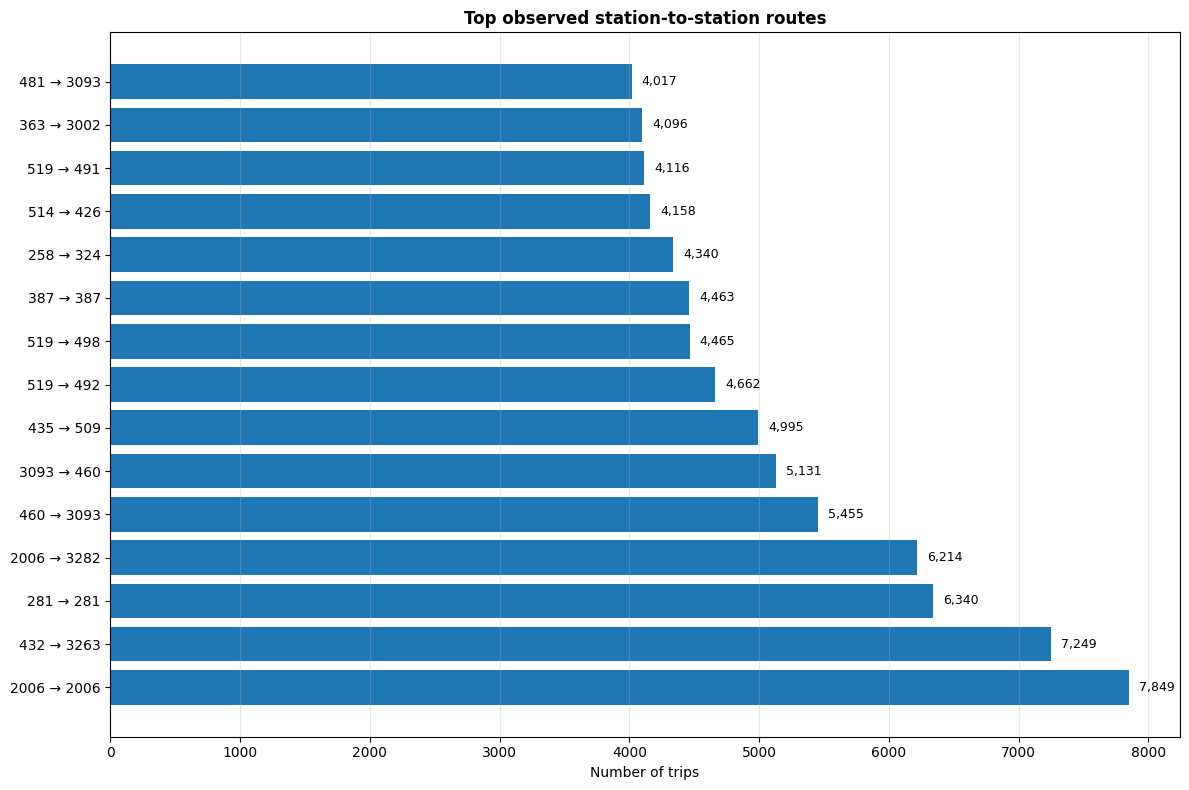


--- GRAPH 2: BIDIRECTIONAL ROUTE PAIRS ---


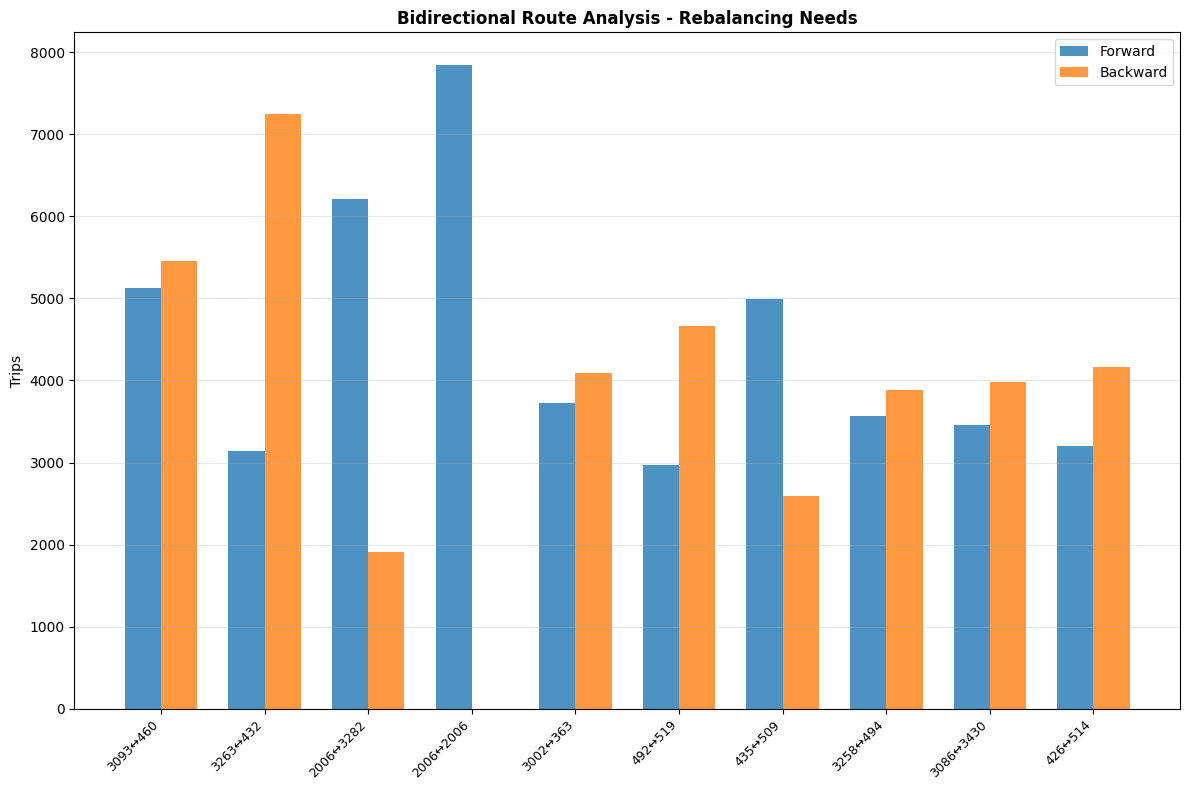


--- GRAPH 3: ZONE-TO-ZONE MOVEMENT PATTERNS ---


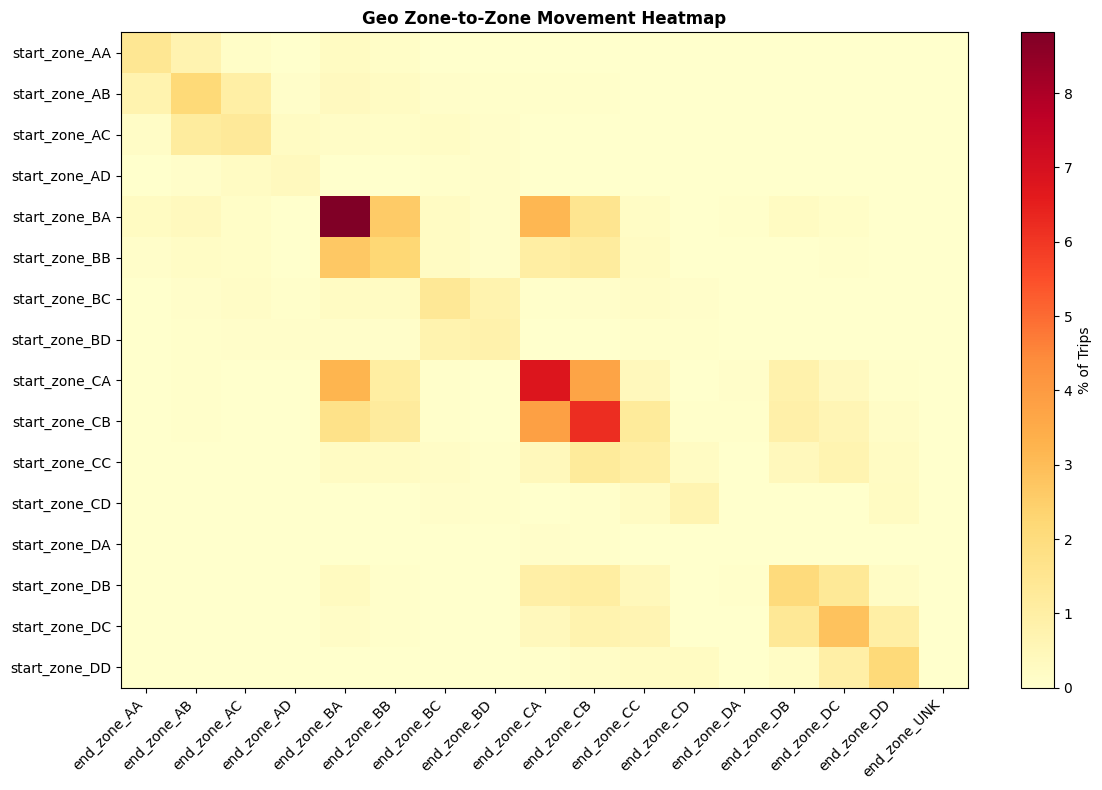


--- GRAPH 4: ASSOCIATION RULE PAIRS ---


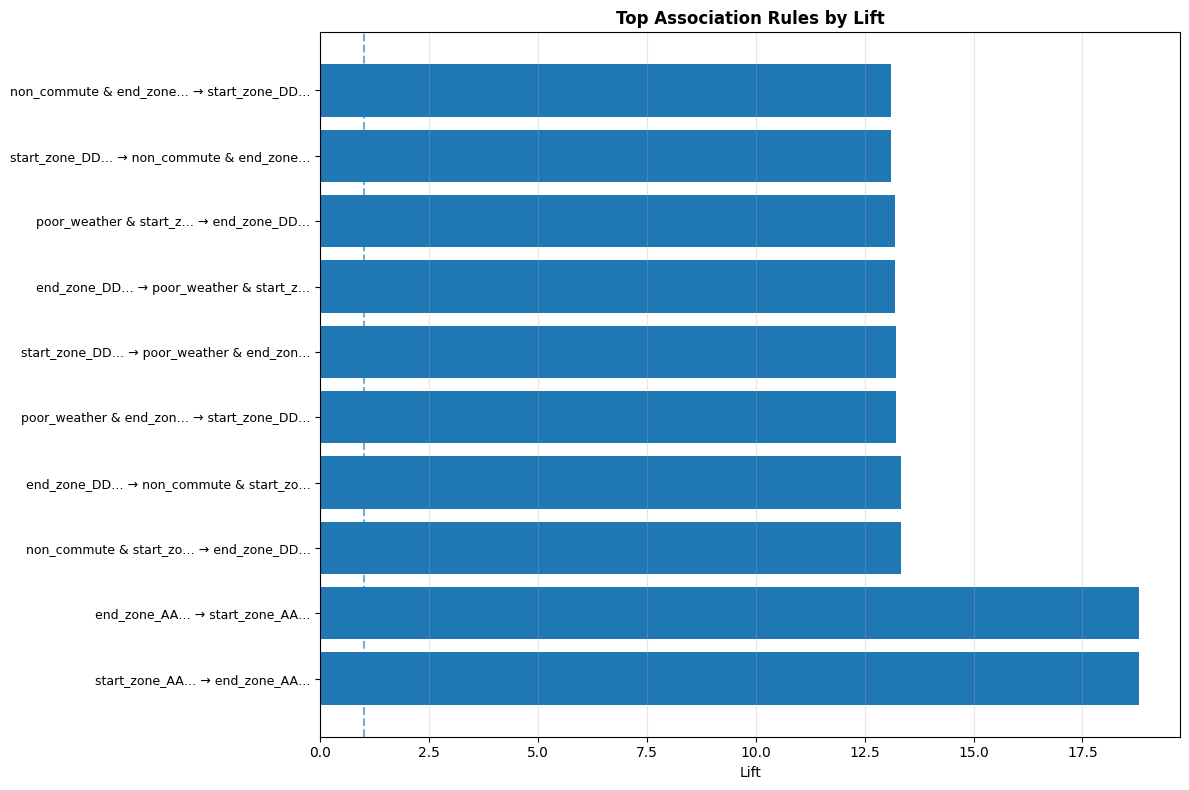


--- GRAPH 5: COMMUTE PATTERN DISTRIBUTION ---


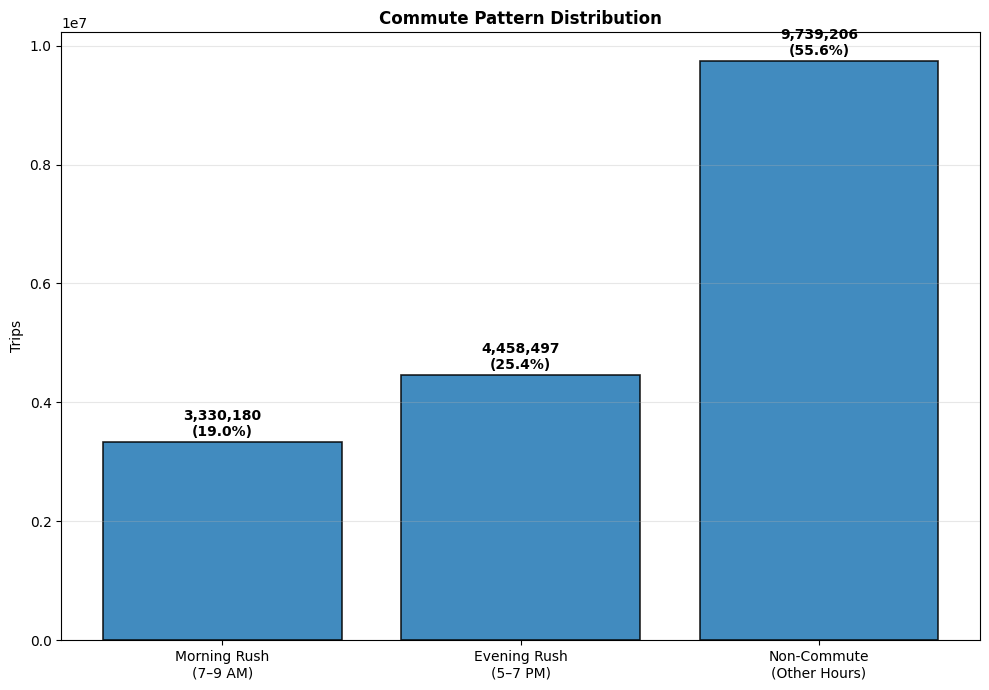


SUMMARY: ALL DISCOVERED PAIRS AND PATTERNS
1. Station Pairs:       347,178
2. Bidirectional Pairs: 200,466
3. Zone Connections:    268
4. Association Rules:   258
5. Frequent Itemsets:   278

Key Insights:
- Rush hours account for 44.4% of trips
- Top route carries 0.04% of total traffic
- Rebalancing needed for 4 of top 10 bidirectional pairs


In [41]:
print("FULL PIPELINE: PATTERN MINING + VISUALIZATIONS")

needed_vars = [
    "simplified_trans", "frequent_itemsets", "rules",
    "commute_patterns", "weather_patterns",
    "route_counter", "all_transactions"
]

missing = [v for v in needed_vars if v not in globals()]

if missing:
    print(f"\nMining results missing: {missing}")
    print(" Running mining step now...\n")

    # Top routes (text summary)
    top_10_routes = sorted(route_counter.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 Most Frequent Routes (Full Dataset):")
    total_trips = max(len(all_transactions), 1)
    for i, (route, count) in enumerate(top_10_routes, 1):
        s1, s2 = route.split("_to_")
        pct = count / total_trips * 100
        print(f"  {i:2}. {s1} → {s2}: {count:,} trips ({pct:.2f}%)")

    # GEO zones
    stations_geo = (
        dfm[["start_station_id", "start_station_latitude", "start_station_longitude"]]
        .dropna()
        .drop_duplicates()
    )

    stations_geo["lat_q"] = pd.qcut(
        stations_geo["start_station_latitude"], q=4, labels=["A", "B", "C", "D"]
    )
    stations_geo["lon_q"] = pd.qcut(
        stations_geo["start_station_longitude"], q=4, labels=["A", "B", "C", "D"]
    )

    stations_geo["geo_zone"] = (
        stations_geo["lat_q"].astype(str) + stations_geo["lon_q"].astype(str)
    )
    zone_map = dict(
        zip(stations_geo["start_station_id"].astype(int), stations_geo["geo_zone"])
    )

    def simplify_transactions_full(transactions_list, zone_map):
        simplified = []
        for trans in transactions_list:
            simple_trans = []
            for item in trans:
                if item in {"morning_commute", "evening_commute", "non_commute"}:
                    simple_trans.append(item)
                elif item in {"good_weather", "poor_weather"}:
                    simple_trans.append(item)
                elif item.startswith("start_"):
                    try:
                        sid = int(item.split("_")[1])
                        z = zone_map.get(sid, "UNK")
                        simple_trans.append(f"start_zone_{z}")
                    except Exception:
                        pass
                elif item.startswith("end_"):
                    try:
                        sid = int(item.split("_")[1])
                        z = zone_map.get(sid, "UNK")
                        simple_trans.append(f"end_zone_{z}")
                    except Exception:
                        pass
            if simple_trans:
                simplified.append(simple_trans)
        return simplified

    print("Creating simplified transactions from ALL trips...")
    simplified_trans = simplify_transactions_full(all_transactions, zone_map)
    print(f"Transactions for mining: {len(simplified_trans):,} / {len(all_transactions):,}")

    print("Sparse encoding transactions...")
    te = TransactionEncoder()
    te_ary_sparse = te.fit(simplified_trans).transform(simplified_trans, sparse=True)
    df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary_sparse, columns=te.columns_)
    print(f"Encoded matrix shape: {df_encoded.shape}")
    print(f"Unique simplified items: {len(te.columns_)}")

    MIN_SUPPORT = 0.01
    MAX_LEN = 3

    try:
        print("Running Apriori (sparse, full data)...")
        frequent_itemsets = apriori(
            df_encoded,
            min_support=MIN_SUPPORT,
            use_colnames=True,
            max_len=MAX_LEN,
            low_memory=True,
        )
        algo_used = "apriori"
    except MemoryError:
        print(" Apriori OOM. Falling back to FP-Growth...")
        frequent_itemsets = fpgrowth(
            df_encoded,
            min_support=MIN_SUPPORT,
            use_colnames=True,
            max_len=MAX_LEN,
        )
        algo_used = "fpgrowth"

    print(f"Frequent patterns found ({algo_used}): {len(frequent_itemsets)}")

    if len(frequent_itemsets) > 1:
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
        rules = rules.sort_values("lift", ascending=False)
        print(f"Association rules generated: {len(rules)}")
    else:
        rules = pd.DataFrame()
        print("Not enough frequent patterns for association rules.")

    commute_patterns = {"morning": 0, "evening": 0, "non_commute": 0}
    weather_patterns = {"good": 0, "poor": 0}

    for trans in all_transactions:
        s = set(trans)
        if "morning_commute" in s:
            commute_patterns["morning"] += 1
        elif "evening_commute" in s:
            commute_patterns["evening"] += 1
        else:
            commute_patterns["non_commute"] += 1

        if "good_weather" in s:
            weather_patterns["good"] += 1
        else:
            weather_patterns["poor"] += 1

    total_trans = max(len(all_transactions), 1)

    print("\nCommute Patterns:")
    print(
        f"  Morning rush: {commute_patterns['morning']:,} "
        f"({commute_patterns['morning']/total_trans*100:.1f}%)"
    )
    print(
        f"  Evening rush: {commute_patterns['evening']:,} "
        f"({commute_patterns['evening']/total_trans*100:.1f}%)"
    )
    print(
        f"  Non-commute : {commute_patterns['non_commute']:,} "
        f"({commute_patterns['non_commute']/total_trans*100:.1f}%)"
    )

    print("\nWeather Impact:")
    print(
        f"  Good weather trips: {weather_patterns['good']:,} "
        f"({weather_patterns['good']/total_trans*100:.1f}%)"
    )
    print(
        f"  Poor weather trips: {weather_patterns['poor']:,} "
        f"({weather_patterns['poor']/total_trans*100:.1f}%)"
    )

else:
    print("Mining results already exist")
    total_trans = max(len(all_transactions), 1)

print("COMPREHENSIVE PATTERN ANALYSIS WITH VISUALIZATIONS")

# GRAPH 1: Top station-to-station routes
print("\n--- GRAPH 1: TOP STATION-TO-STATION ROUTES ---")
top_15_routes = sorted(route_counter.items(), key=lambda x: x[1], reverse=True)[:15]
route_labels = [r.replace("_to_", " → ") for r, _ in top_15_routes]
route_counts = [c for _, c in top_15_routes]

plt.figure(figsize=(12, 8))
plt.barh(range(len(route_labels)), route_counts)
plt.yticks(range(len(route_labels)), route_labels, fontsize=10)
plt.xlabel("Number of trips")
plt.title("Top observed station-to-station routes", fontweight="bold")
for i, count in enumerate(route_counts):
    plt.text(count + max(route_counts) * 0.01, i, f"{count:,}", va="center", fontsize=9)
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

# GRAPH 2: Bidirectional route pairs
print("\n--- GRAPH 2: BIDIRECTIONAL ROUTE PAIRS ---")
bidirectional_pairs = {}
for route, count in route_counter.items():
    s1, s2 = route.split("_to_")
    key = tuple(sorted([s1, s2]))
    if key not in bidirectional_pairs:
        bidirectional_pairs[key] = {"forward": 0, "backward": 0, "total": 0}
    if (s1, s2) == key:
        bidirectional_pairs[key]["forward"] += count
    else:
        bidirectional_pairs[key]["backward"] += count
    bidirectional_pairs[key]["total"] += count

top_pairs = sorted(
    bidirectional_pairs.items(), key=lambda x: x[1]["total"], reverse=True
)[:10]

pair_labels = [f"{s1}↔{s2}" for (s1, s2), _ in top_pairs]
forward_counts = [c["forward"] for _, c in top_pairs]
backward_counts = [c["backward"] for _, c in top_pairs]

x = np.arange(len(pair_labels))
width = 0.35

plt.figure(figsize=(12, 8))
plt.bar(x - width / 2, forward_counts, width, label="Forward", alpha=0.8)
plt.bar(x + width / 2, backward_counts, width, label="Backward", alpha=0.8)
plt.xticks(x, pair_labels, rotation=45, ha="right", fontsize=9)
plt.ylabel("Trips")
plt.title("Bidirectional Route Analysis - Rebalancing Needs", fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

# GRAPH 3: Zone-to-zone movement patterns
print("\n--- GRAPH 3: ZONE-TO-ZONE MOVEMENT PATTERNS ---")
zone_connections = {}
for trans in simplified_trans:
    start_zones = [item for item in trans if item.startswith("start_zone_")]
    end_zones = [item for item in trans if item.startswith("end_zone_")]
    for start in start_zones:
        for end in end_zones:
            pair = f"{start} → {end}"
            zone_connections[pair] = zone_connections.get(pair, 0) + 1

start_zone_vals = sorted(
    {z for t in simplified_trans for z in t if z.startswith("start_zone_")}
)
end_zone_vals = sorted(
    {z for t in simplified_trans for z in t if z.startswith("end_zone_")}
)

matrix = np.zeros((len(start_zone_vals), len(end_zone_vals)))
for pair, count in zone_connections.items():
    start, end = pair.split(" → ")
    i = start_zone_vals.index(start)
    j = end_zone_vals.index(end)
    matrix[i, j] = count

matrix_pct = (matrix / matrix.sum()) * 100 if matrix.sum() > 0 else matrix

plt.figure(figsize=(12, 8))
im = plt.imshow(matrix_pct, cmap="YlOrRd", aspect="auto")
plt.colorbar(im, label="% of Trips")
plt.xticks(range(len(end_zone_vals)), end_zone_vals, rotation=45, ha="right")
plt.yticks(range(len(start_zone_vals)), start_zone_vals)
plt.title("Geo Zone-to-Zone Movement Heatmap", fontweight="bold")
plt.tight_layout()
plt.show()

# GRAPH 4: Association rule pairs
print("\n--- GRAPH 4: ASSOCIATION RULE PAIRS ---")
if len(rules) > 0:
    top_rules = rules.nlargest(10, "lift")
    rule_labels = [
        f'{" & ".join(list(r["antecedents"]))[:22]}… → '
        f'{" & ".join(list(r["consequents"]))[:22]}…'
        for _, r in top_rules.iterrows()
    ]
    lifts = top_rules["lift"].values

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(rule_labels)), lifts)
    plt.yticks(range(len(rule_labels)), rule_labels, fontsize=9)
    plt.xlabel("Lift")
    plt.title("Top Association Rules by Lift", fontweight="bold")
    plt.axvline(1, linestyle="--", alpha=0.6)
    plt.grid(True, alpha=0.3, axis="x")
    plt.tight_layout()
    plt.show()
else:
    print("No association rules found.")

# GRAPH 5: Commute distribution
print("\n--- GRAPH 5: COMMUTE PATTERN DISTRIBUTION ---")
categories = [
    "Morning Rush\n(7–9 AM)",
    "Evening Rush\n(5–7 PM)",
    "Non-Commute\n(Other Hours)",
]
values = [
    commute_patterns["morning"],
    commute_patterns["evening"],
    commute_patterns["non_commute"],
]

plt.figure(figsize=(10, 7))
bars = plt.bar(range(3), values, alpha=0.85, edgecolor="black", linewidth=1.2)
plt.xticks(range(3), categories)
plt.ylabel("Trips")
plt.title("Commute Pattern Distribution", fontweight="bold")
plt.grid(True, alpha=0.3, axis="y")

for bar, value in zip(bars, values):
    pct = value / total_trans * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(values) * 0.01,
        f"{value:,}\n({pct:.1f}%)",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "=" * 70)
print("SUMMARY: ALL DISCOVERED PAIRS AND PATTERNS")
print("=" * 70)

print(f"1. Station Pairs:       {len(route_counter):,}")
print(f"2. Bidirectional Pairs: {len(bidirectional_pairs):,}")
print(f"3. Zone Connections:    {len(zone_connections):,}")
print(f"4. Association Rules:   {len(rules):,}")
print(f"5. Frequent Itemsets:   {len(frequent_itemsets):,}")

rush_pct = (
    (commute_patterns["morning"] + commute_patterns["evening"]) / total_trans * 100
)
top_route_pct = (
    top_15_routes[0][1] / total_trans * 100 if top_15_routes else 0
)
imbalanced_pairs = sum(
    1
    for (_, c) in top_pairs
    if c["total"] > 0 and abs(c["forward"] - c["backward"]) / c["total"] > 0.3
)

print("\nKey Insights:")
print(f"- Rush hours account for {rush_pct:.1f}% of trips")
print(f"- Top route carries {top_route_pct:.2f}% of total traffic")
print(
    f"- Rebalancing needed for {imbalanced_pairs} of top 10 bidirectional pairs"
)


### 7.1 Pattern Mining Results

Map the most frequent routes to see their real-world locations in NYC

In [12]:
# Extract top 10 routes and get their station coordinates
print("TOP 10 MOST FREQUENT ROUTES - GEOGRAPHIC MAPPING")

route_data = []
for route, count in top_10_routes:
    #route format is "start_to_end"
    parts = route.split("_to_")
    if len(parts) == 2:
        start_id = int(parts[0])
        end_id = int(parts[1])
        route_data.append({
            'route': route,
            'start_id': start_id,
            'end_id': end_id,
            'count': count,
            'pct': (count / total_trips * 100)
        })

routes_df = pd.DataFrame(route_data)

#merge with station coordinates
routes_with_coords = routes_df.merge(
    stations[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    left_on='start_id',
    right_on='start_station_id',
    how='left'
).merge(
    stations[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    left_on='end_id',
    right_on='start_station_id',
    how='left',
    suffixes=('_start', '_end')
)

print(f"\n Mapped {len(routes_with_coords)} routes to coordinates")
print("\nRoute Details:")
for idx, row in routes_with_coords.iterrows():
    same_station = " SAME STATION" if row['start_id'] == row['end_id'] else "→"
    print(f"{idx+1}. Station {row['start_id']} {same_station} {row['end_id']}: "
          f"{row['count']:,} trips ({row['pct']:.3f}%)")
    if row['start_id'] != row['end_id']:
        print(f"   From: ({row['start_station_latitude_start']:.4f}, {row['start_station_longitude_start']:.4f})")
        print(f"   To:   ({row['start_station_latitude_end']:.4f}, {row['start_station_longitude_end']:.4f})")
    else:
        print(f"   At:   ({row['start_station_latitude_start']:.4f}, {row['start_station_longitude_start']:.4f})")

routes_with_coords.head(10)

TOP 10 MOST FREQUENT ROUTES - GEOGRAPHIC MAPPING

 Mapped 10 routes to coordinates

Route Details:
1. Station 2006  SAME STATION 2006: 7,849 trips (0.045%)
   At:   (40.7659, -73.9763)
2. Station 432 → 3263: 7,249 trips (0.041%)
   From: (40.7262, -73.9838)
   To:   (40.7295, -73.9908)
3. Station 281  SAME STATION 281: 6,340 trips (0.036%)
   At:   (40.7644, -73.9737)
4. Station 2006 → 3282: 6,214 trips (0.035%)
   From: (40.7659, -73.9763)
   To:   (40.7831, -73.9594)
5. Station 460 → 3093: 5,455 trips (0.031%)
   From: (40.7129, -73.9659)
   To:   (40.7175, -73.9585)
6. Station 3093 → 460: 5,131 trips (0.029%)
   From: (40.7175, -73.9585)
   To:   (40.7129, -73.9659)
7. Station 435 → 509: 4,995 trips (0.028%)
   From: (40.7417, -73.9942)
   To:   (40.7455, -74.0020)
8. Station 519 → 492: 4,662 trips (0.027%)
   From: (40.7519, -73.9777)
   To:   (40.7502, -73.9909)
9. Station 519 → 498: 4,465 trips (0.025%)
   From: (40.7519, -73.9777)
   To:   (40.7485, -73.9881)
10. Station 387  SA

route  start_id  end_id  count       pct  start_station_id_start  \
0  2006_to_2006      2006    2006   7849  0.044780                  2006.0   
1   432_to_3263       432    3263   7249  0.041357                   432.0   
2    281_to_281       281     281   6340  0.036171                   281.0   
3  2006_to_3282      2006    3282   6214  0.035452                  2006.0   
4   460_to_3093       460    3093   5455  0.031122                   460.0   
5   3093_to_460      3093     460   5131  0.029273                  3093.0   
6    435_to_509       435     509   4995  0.028497                   435.0   
7    519_to_492       519     492   4662  0.026598                   519.0   
8    519_to_498       519     498   4465  0.025474                   519.0   
9    387_to_387       387     387   4463  0.025462                   387.0   

   start_station_latitude_start  start_station_longitude_start  \
0                     40.765909                     -73.976342   
1                     40.726218                     -73.983799   
2                     40.764397                     -73.973715   
3                     40.765909                     -73.976342   
4                     40.712859                     -73.965903   
5                     40.717452                     -73.958509   
6                     40.741740                     -73.994156   
7                     40.751873                     -73.977706   
8                     40.751873                     -73.977706   
9                     40.712733                     -74.004607   

   start_station_id_end  start_station_latitude_end  \
0                2006.0                   40.765909   
1                3263.0                   40.729515   
2                 281.0                   40.764397   
3                3282.0                   40.783070   
4                3093.0                   40.717452   
5                 460.0                   40.712859   
6                 509.0                   40.745497   
7                 492.0                   40.750200   
8                 498.0                   40.748549   
9                 387.0                   40.712733   

   start_station_longitude_end  
0                   -73.976342  
1                   -73.990753  
2                   -73.973715  
3                   -73.959390  
4                   -73.958509  
5                   -73.965903  
6                   -74.001971  
7                   -73.990931  
8                   -73.988084  
9                   -74.004607

# 8. User Profile Aggregation

In [13]:

print("USER CLUSTERING - AGGREGATING PROFILES")

all_profiles = pd.concat(user_profiles_list, ignore_index=True)

user_profiles = all_profiles.groupby(['birth_year', 'gender']).agg({
    ('tripduration', 'mean'): 'mean',
    ('tripduration', 'std'): 'mean',
    ('tripduration', 'count'): 'sum',
    ('trip_duration_min', 'mean'): 'mean',
    ('trip_duration_min', 'median'): 'mean',
    ('start_station_id', 'nunique'): 'max',
    ('end_station_id', 'nunique'): 'max',
    ('hour', 'mean'): 'mean',
    ('hour', 'std'): 'mean',
    ('is_weekend', 'mean'): 'mean',
    ('day_of_week', '<lambda>'): 'mean',
    ('cycling_score', 'mean'): 'mean',
    ('cycling_score', 'std'): 'mean',
    ('temp_celsius', 'mean'): 'mean',
    ('is_dry', 'mean'): 'mean',
    ('usertype', '<lambda>'): 'mean'
}).reset_index()

user_profiles.columns = [
    'birth_year', 'gender', 'avg_duration', 'std_duration', 'trip_count',
    'avg_trip_min', 'median_trip_min', 'unique_start_stations', 'unique_end_stations',
    'avg_hour', 'std_hour', 'weekend_ratio', 'preferred_day',
    'avg_cycling_score', 'std_cycling_score', 'avg_temp_preference', 
    'dry_weather_ratio', 'is_subscriber'
]

#adding derived features
user_profiles['age'] = 2018 - user_profiles['birth_year']
user_profiles['station_diversity'] = (user_profiles['unique_start_stations'] + 
                                      user_profiles['unique_end_stations']) / 2
user_profiles['trips_per_month'] = user_profiles['trip_count'] / 3

user_profiles_clean = user_profiles.dropna()
print(f"User profiles created: {len(user_profiles_clean)} unique user groups")
print(f"From {user_profiles_clean['trip_count'].sum():.0f} total trips")

USER CLUSTERING - AGGREGATING PROFILES
User profiles created: 212 unique user groups
From 17527880 total trips


## 9. Hierarchical Clustering

In [14]:
print("HIERARCHICAL CLUSTERING ANALYSIS")

#selecting features
clustering_features = [
    'age', 'avg_duration', 'trip_count', 'station_diversity',
    'avg_trip_min', 'weekend_ratio', 'avg_hour',
    'avg_cycling_score', 'dry_weather_ratio', 'trips_per_month'
]

available_features = [col for col in clustering_features if col in user_profiles_clean.columns]
X = user_profiles_clean[available_features].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Clustering matrix: {X_scaled.shape}")

#trying to find best linkage method
linkage_methods = ['ward', 'average', 'complete']
best_method = None
best_score = float('inf')

for method in linkage_methods:
    linkage_test = linkage(X_scaled, method=method)
    clusters_test = fcluster(linkage_test, 4, criterion='maxclust')
    db_score = davies_bouldin_score(X_scaled, clusters_test)
    print(f"  {method}: Davies-Bouldin = {db_score:.3f}")
    if db_score < best_score:
        best_score = db_score
        best_method = method

print(f"\nBest method: {best_method}")

#clustering
linkage_matrix = linkage(X_scaled, method=best_method)

#find optimal k
db_scores = []
sil_scores = []
k_range = range(3, 9)

for k in k_range:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    db = davies_bouldin_score(X_scaled, clusters)
    sil = silhouette_score(X_scaled, clusters)
    db_scores.append(db)
    sil_scores.append(sil)
    print(f"  k={k}: DB={db:.3f}, Silhouette={sil:.3f}")

optimal_k = k_range[np.argmin(db_scores)]
print(f"\nOptimal clusters: {optimal_k}")

#final clustering
final_clusters = fcluster(linkage_matrix, optimal_k, criterion='maxclust')
user_profiles_clean['cluster'] = final_clusters

HIERARCHICAL CLUSTERING ANALYSIS
Clustering matrix: (212, 10)
  ward: Davies-Bouldin = 1.282
  average: Davies-Bouldin = 0.176
  complete: Davies-Bouldin = 0.589

Best method: average
  k=3: DB=0.178, Silhouette=0.726
  k=4: DB=0.176, Silhouette=0.714
  k=5: DB=0.180, Silhouette=0.698
  k=6: DB=0.409, Silhouette=0.634
  k=7: DB=0.205, Silhouette=0.616
  k=8: DB=0.238, Silhouette=0.486

Optimal clusters: 4


C:\Users\UPASANA\AppData\Local\Temp\ipykernel_29768\1245551108.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profiles_clean['cluster'] = final_clusters


### 9.1 Clustering Visualizations


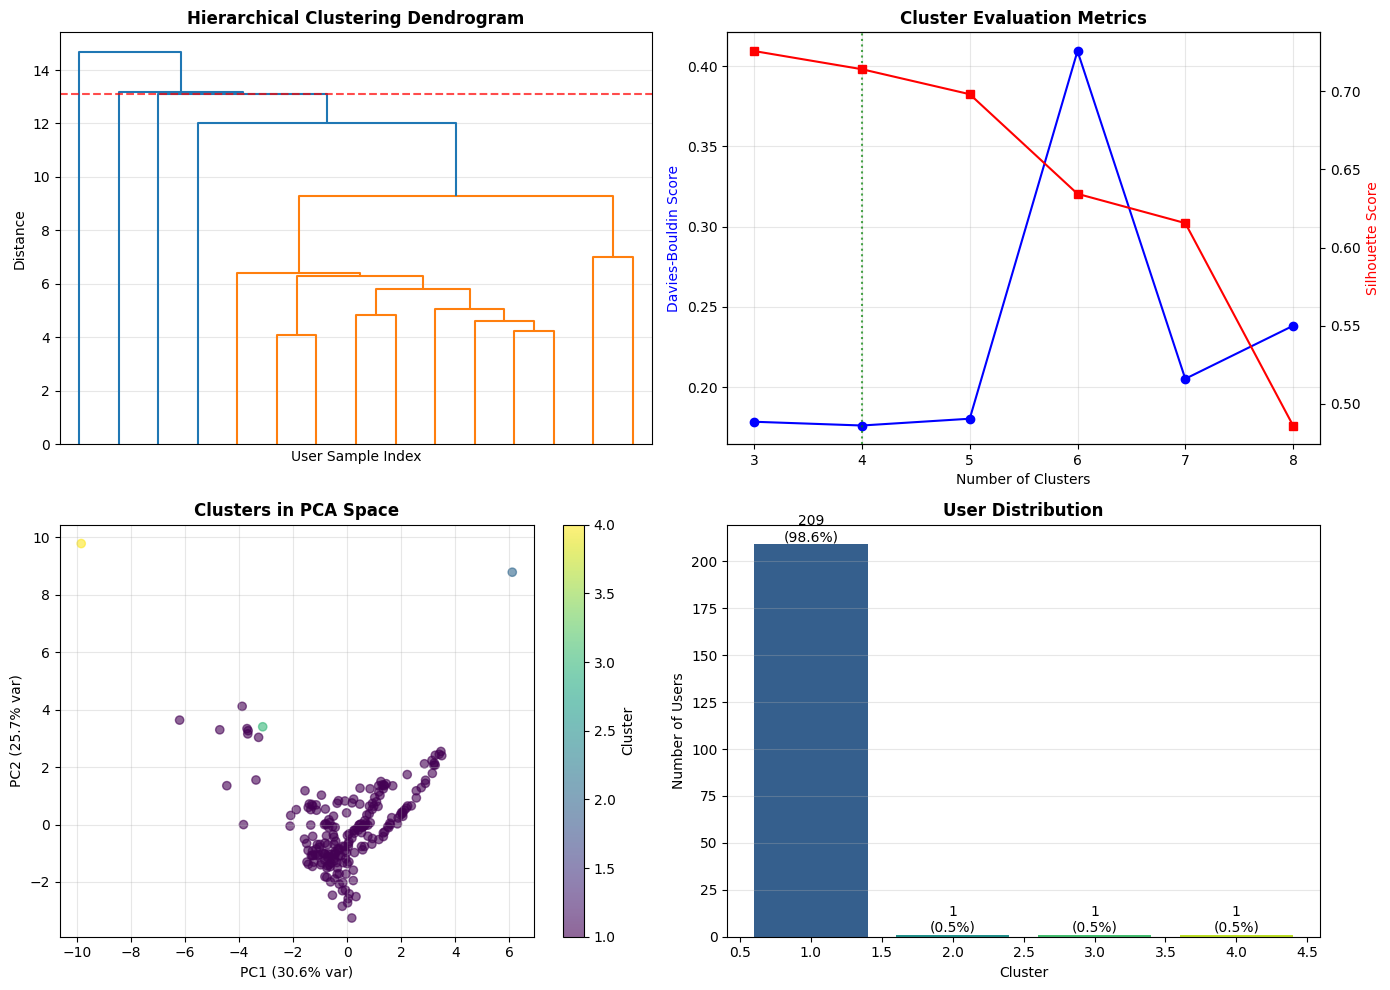

In [15]:
fig = plt.figure(figsize=(14, 10))

#dendrogram
ax1 = plt.subplot(2, 2, 1)
dendrogram(linkage_matrix, truncate_mode='lastp', p=15, no_labels=True, ax=ax1)
ax1.axhline(y=linkage_matrix[-(optimal_k-1), 2], color='r', linestyle='--', alpha=0.7)
ax1.set_title('Hierarchical Clustering Dendrogram', fontweight='bold')
ax1.set_xlabel('User Sample Index')
ax1.set_ylabel('Distance')
ax1.grid(True, alpha=0.3)

# Metrics
ax2 = plt.subplot(2, 2, 2)
k_range_plot = list(range(3, 3 + len(db_scores)))
ax2.plot(k_range_plot, db_scores, 'b-o', label='Davies-Bouldin')
ax2_twin = ax2.twinx()
ax2_twin.plot(k_range_plot, sil_scores, 'r-s', label='Silhouette')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Davies-Bouldin Score', color='b')
ax2_twin.set_ylabel('Silhouette Score', color='r')
ax2.axvline(x=optimal_k, color='green', linestyle=':', alpha=0.7)
ax2.set_title('Cluster Evaluation Metrics', fontweight='bold')
ax2.grid(True, alpha=0.3)

#   PCA visualization
ax3 = plt.subplot(2, 2, 3)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ax=ax3, label='Cluster')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax3.set_title('Clusters in PCA Space', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Distribution
ax4 = plt.subplot(2, 2, 4)
cluster_sizes = user_profiles_clean['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(cluster_sizes)))
bars = ax4.bar(cluster_sizes.index, cluster_sizes.values, color=colors)
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Number of Users')
ax4.set_title('User Distribution', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, cluster_sizes.values):
    pct = count / len(user_profiles_clean) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{count}\n({pct:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 9.2 Cluster Analysis

In [16]:
#analyzing  each cluster
for cluster_id in range(1, optimal_k + 1):
    cluster = user_profiles_clean[user_profiles_clean['cluster'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}: {len(cluster)} users ({len(cluster)/len(user_profiles_clean)*100:.1f}%)")
    print("-" * 50)
    print(f"Age: {cluster['age'].mean():.1f} years")
    print(f"Trips/month: {cluster['trips_per_month'].mean():.1f}")
    print(f"Trip duration: {cluster['avg_trip_min'].mean():.1f} min")
    print(f"Weekend usage: {cluster['weekend_ratio'].mean():.1%}")
    print(f"Station diversity: {cluster['station_diversity'].mean():.1f}")
    print(f"Weather score: {cluster['avg_cycling_score'].mean():.1f}/100")

#     Summary table
cluster_summary = user_profiles_clean.groupby('cluster').agg({
    'age': 'mean',
    'trip_count': 'mean',
    'avg_trip_min': 'mean',
    'weekend_ratio': 'mean',
    'station_diversity': 'mean',
    'avg_cycling_score': 'mean'
}).round(2)

print("CLUSTER SUMMARY")
print(cluster_summary)
print("\nAnalysis complete")


CLUSTER 1: 209 users (98.6%)
--------------------------------------------------
Age: 51.0 years
Trips/month: 25754.3
Trip duration: 15.1 min
Weekend usage: 23.2%
Station diversity: 339.9
Weather score: 56.9/100

CLUSTER 2: 1 users (0.5%)
--------------------------------------------------
Age: 49.0 years
Trips/month: 459984.0
Trip duration: 26.1 min
Weekend usage: 41.4%
Station diversity: 764.5
Weather score: 58.3/100

CLUSTER 3: 1 users (0.5%)
--------------------------------------------------
Age: 88.0 years
Trips/month: 2.0
Trip duration: 13.2 min
Weekend usage: 83.3%
Station diversity: 3.0
Weather score: 34.8/100

CLUSTER 4: 1 users (0.5%)
--------------------------------------------------
Age: 73.0 years
Trips/month: 1.3
Trip duration: 60.5 min
Weekend usage: 100.0%
Station diversity: 3.0
Weather score: 57.5/100
CLUSTER SUMMARY
           age  trip_count  avg_trip_min  weekend_ratio  station_diversity  \
cluster                                                                      

## 10. Temporal Demand Analysis

TEMPORAL DEMAND ANALYSIS & PATTERNS

Peak vs Off-Peak Analysis:
        trip_duration_min       start_station_id usertype
                     mean   std            count <lambda>
is_peak                                                  
0                   14.61  24.1          9739206     0.86
1                   13.57  20.0          7788677     0.93


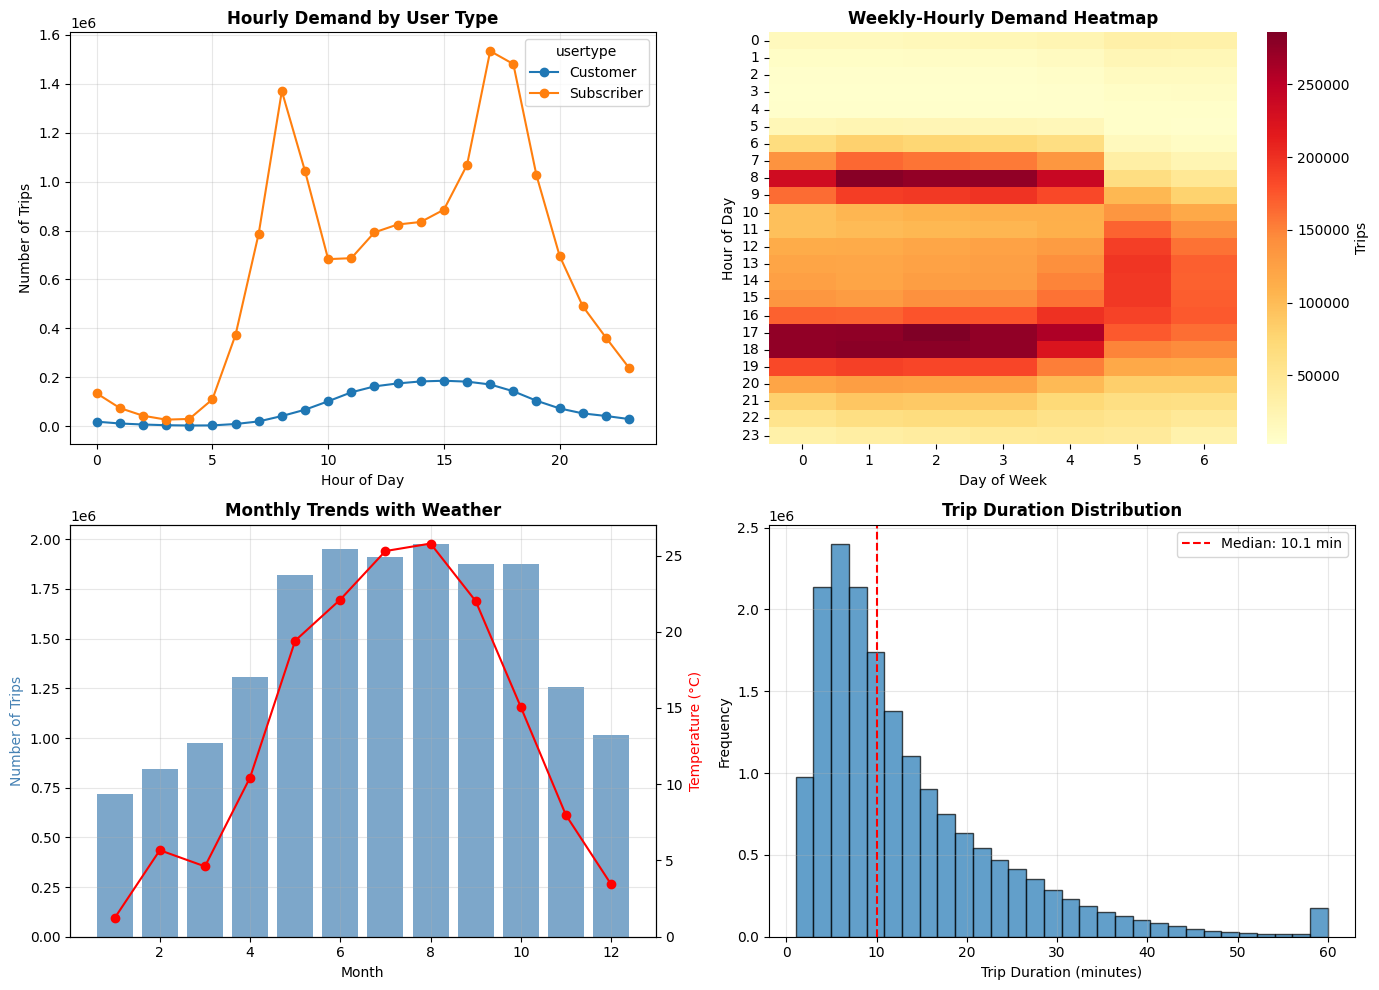

In [17]:

print("TEMPORAL DEMAND ANALYSIS & PATTERNS")

#hourly demand patterns by user type
hourly_patterns = dfm.groupby([dfm['start_hour'].dt.hour, 'usertype']).agg({
    'start_station_id': 'count',
    'trip_duration_min': 'mean',
    'cycling_score': 'mean'
}).rename(columns={'start_station_id': 'trips'}).reset_index()

#peak vs Off-peak analysis
peak_hours = [7, 8, 9, 17, 18, 19]
dfm['is_peak'] = dfm['hour'].isin(peak_hours).astype(int)

peak_analysis = dfm.groupby('is_peak').agg({
    'trip_duration_min': ['mean', 'std'],
    'start_station_id': 'count',
    'usertype': lambda x: (x == 'Subscriber').mean()
}).round(2)

print("\nPeak vs Off-Peak Analysis:")
print(peak_analysis)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hourly pattern by user type
pivot_hourly = hourly_patterns.pivot(index='start_hour', columns='usertype', values='trips')
pivot_hourly.plot(ax=axes[0,0], marker='o')
axes[0,0].set_title('Hourly Demand by User Type', fontweight='bold')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Number of Trips')
axes[0,0].grid(True, alpha=0.3)

#weekly pattern heatmap
weekly_hourly = dfm.groupby(['day_of_week', 'hour']).size().reset_index(name='trips')
weekly_pivot = weekly_hourly.pivot(index='hour', columns='day_of_week', values='trips')
sns.heatmap(weekly_pivot, cmap='YlOrRd', ax=axes[0,1], cbar_kws={'label': 'Trips'})
axes[0,1].set_title('Weekly-Hourly Demand Heatmap', fontweight='bold')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Hour of Day')

#monthly trend
monthly_trend = dfm.groupby('month').agg({
    'start_station_id': 'count',
    'cycling_score': 'mean',
    'temp_celsius': 'mean'
}).rename(columns={'start_station_id': 'trips'})

ax1 = axes[1,0]
ax1.bar(monthly_trend.index, monthly_trend['trips'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Trips', color='steelblue')
ax1.set_title('Monthly Trends with Weather', fontweight='bold')
ax2 = ax1.twinx()
ax2.plot(monthly_trend.index, monthly_trend['temp_celsius'], 'r-o', label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='red')
ax1.grid(True, alpha=0.3)

# Duration distribution
axes[1,1].hist(dfm['trip_duration_min'].clip(0, 60), bins=30, edgecolor='black', alpha=0.7)
axes[1,1].axvline(dfm['trip_duration_min'].median(), color='red', linestyle='--', label=f'Median: {dfm["trip_duration_min"].median():.1f} min')
axes[1,1].set_xlabel('Trip Duration (minutes)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Trip Duration Distribution', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Weather Correlation Analysis

PEARSON CORRELATION: WEATHER vs TRIP DEMAND

Pearson Correlation Coefficients (Weather vs Trip Count):
Variable                   Correlation      p-value    Significance        Strength
temp_celsius                    0.4425     0.00e+00             *** Moderate positive
apparent_temperature            0.4099     0.00e+00             *** Moderate positive
cycling_score                   0.3415    9.20e-238             *** Moderate positive
is_dry                          0.1279     3.36e-33             ***   Weak positive
wind_kmh                       -0.0141     1.88e-01            n.s.   Weak negative
cloud_cover                    -0.0310     3.80e-03              **   Weak negative
snowfall                       -0.0850     1.69e-15             ***   Weak negative
rain                           -0.1280     2.88e-33             ***   Weak negative
relative_humidity_2m           -0.2730    3.20e-149             ***   Weak negative

Significance levels: *** p<0.001, ** p<0.01, * p<0

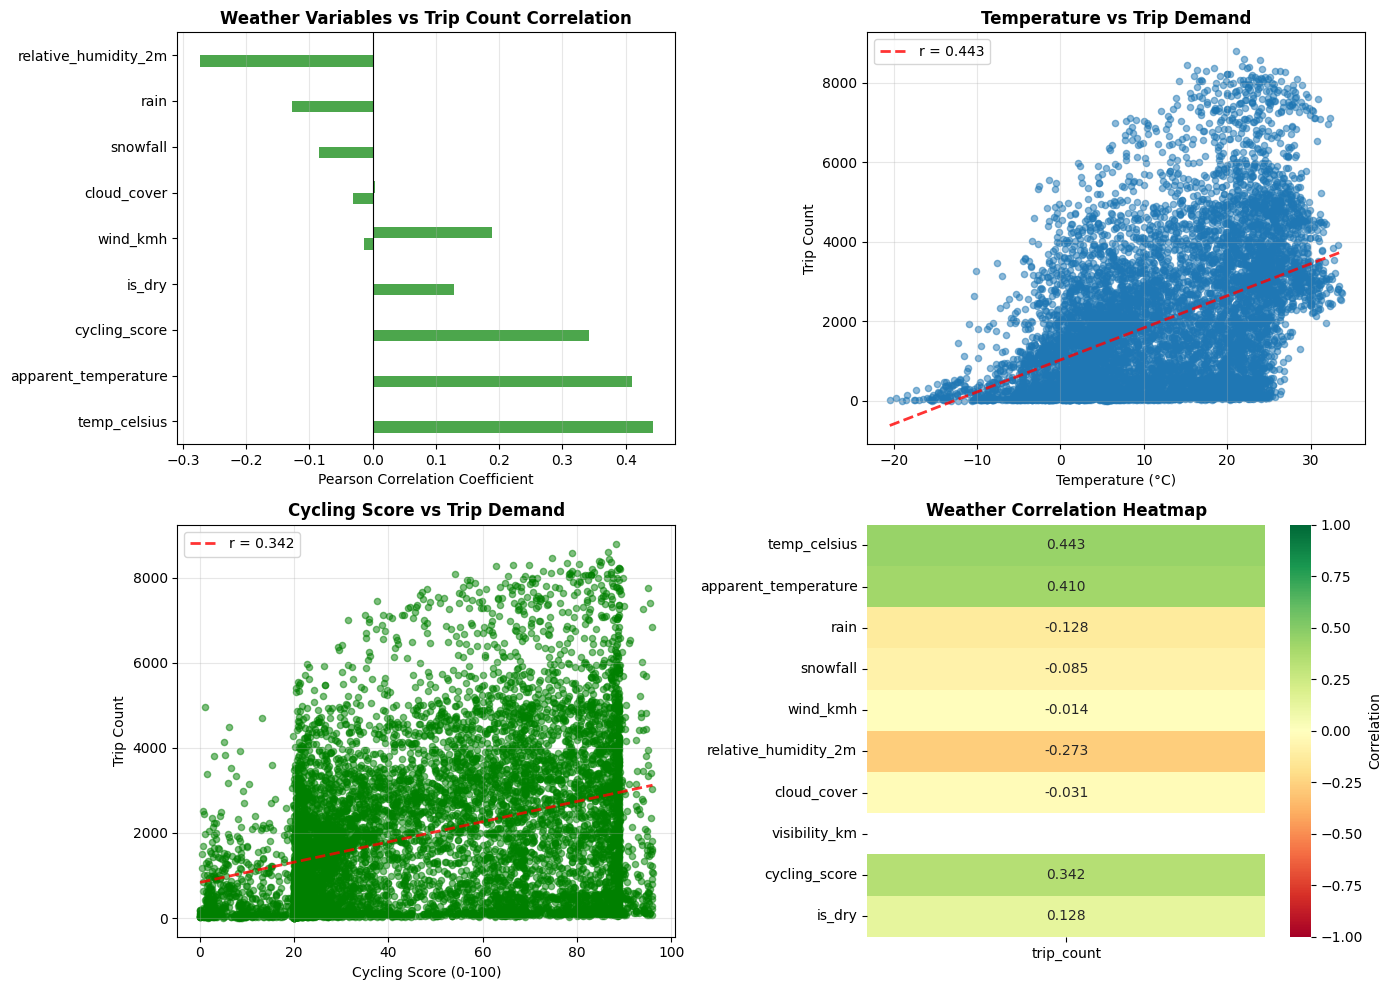

KEY INSIGHTS
 Strongest positive correlation: temp_celsius (r = 0.4425, p = 0.00e+00)
 Strongest negative correlation: relative_humidity_2m (r = -0.2730, p = 3.20e-149)
 8 variables are statistically significant (p < 0.05)
 3 variables show moderate-to-strong correlation (|r| > 0.3)
 Weather (cycling score) explains approximately 11.7% of trip demand variance (R² = 0.117)
 7 variables are highly significant (p < 0.001), indicating robust relationships


In [18]:
print("PEARSON CORRELATION: WEATHER vs TRIP DEMAND")

# Aggregate hourly trip counts with weather variables
hourly_data = dfm.groupby('start_hour').agg({
    'start_station_id': 'count', 
    'temp_celsius': 'mean',
    'apparent_temperature': 'mean',
    'rain': 'mean',
    'snowfall': 'mean',
    'wind_kmh': 'mean',
    'relative_humidity_2m': 'mean',
    'cloud_cover': 'mean',
    'visibility_km': 'mean',
    'cycling_score': 'mean',
    'is_dry': 'mean'
}).rename(columns={'start_station_id': 'trip_count'}).reset_index()

#calculating Pearson correlation with p-values
from scipy.stats import pearsonr

weather_vars = [
    'temp_celsius', 'apparent_temperature', 'rain', 'snowfall', 
    'wind_kmh', 'relative_humidity_2m', 'cloud_cover', 
    'visibility_km', 'cycling_score', 'is_dry'
]

correlations = {}
p_values = {}

for var in weather_vars:
    if var in hourly_data.columns:
        valid_mask = hourly_data[['trip_count', var]].notna().all(axis=1)
        if valid_mask.sum() > 2: 
            corr, p_val = pearsonr(
                hourly_data.loc[valid_mask, 'trip_count'], 
                hourly_data.loc[valid_mask, var]
            )
            correlations[var] = corr
            p_values[var] = p_val

corr_df = pd.DataFrame({
    'Pearson Correlation': correlations,
    'p-value': p_values
})
corr_df['Significant'] = corr_df['p-value'] < 0.05
corr_df = corr_df.sort_values('Pearson Correlation', ascending=False)

print("\nPearson Correlation Coefficients (Weather vs Trip Count):")
print(f"{'Variable':<25} {'Correlation':>12} {'p-value':>12} {'Significance':>15} {'Strength':>15}")


for var, row in corr_df.iterrows():
    corr_value = row['Pearson Correlation']
    p_val = row['p-value']
    strength = "Strong" if abs(corr_value) > 0.5 else "Moderate" if abs(corr_value) > 0.3 else "Weak"
    direction = "positive" if corr_value > 0 else "negative"
    sig_marker = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
    
    print(f"{var:<25} {corr_value:>12.4f} {p_val:>12.2e} {sig_marker:>15} {strength + ' ' + direction:>15}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#  Correlation bar chart
ax1 = axes[0, 0]
colors = ['green' if x > 0 else 'red' for x in corr_df['Pearson Correlation']]
corr_df.plot(kind='barh', ax=ax1, legend=False, color=colors, alpha=0.7)
ax1.set_xlabel('Pearson Correlation Coefficient')
ax1.set_title('Weather Variables vs Trip Count Correlation', fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

#Temperature vs Trip Count scatter
ax2 = axes[0, 1]
ax2.scatter(hourly_data['temp_celsius'], hourly_data['trip_count'], alpha=0.5, s=20)
z = np.polyfit(hourly_data['temp_celsius'].dropna(), 
               hourly_data.loc[hourly_data['temp_celsius'].notna(), 'trip_count'], 1)
p = np.poly1d(z)
ax2.plot(hourly_data['temp_celsius'].sort_values(), 
         p(hourly_data['temp_celsius'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, 
         label=f'r = {correlations["temp_celsius"]:.3f}')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Trip Count')
ax2.set_title('Temperature vs Trip Demand', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cycling Score vs Trip Count
ax3 = axes[1, 0]
ax3.scatter(hourly_data['cycling_score'], hourly_data['trip_count'], alpha=0.5, s=20, color='green')
z = np.polyfit(hourly_data['cycling_score'].dropna(), 
               hourly_data.loc[hourly_data['cycling_score'].notna(), 'trip_count'], 1)
p = np.poly1d(z)
ax3.plot(hourly_data['cycling_score'].sort_values(), 
         p(hourly_data['cycling_score'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, 
         label=f'r = {correlations["cycling_score"]:.3f}')
ax3.set_xlabel('Cycling Score (0-100)')
ax3.set_ylabel('Trip Count')
ax3.set_title('Cycling Score vs Trip Demand', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

#  Correlation heatmap
ax4 = axes[1, 1]
corr_matrix = hourly_data[['trip_count'] + weather_vars].corr()
trip_corr = corr_matrix[['trip_count']].drop('trip_count')
sns.heatmap(trip_corr, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            ax=ax4, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
ax4.set_title('Weather Correlation Heatmap', fontweight='bold')
ax4.set_ylabel('')

plt.tight_layout()
plt.show()

print("KEY INSIGHTS")

strongest_pos = corr_df[corr_df['Pearson Correlation'] > 0].iloc[0]
strongest_neg = corr_df[corr_df['Pearson Correlation'] < 0].iloc[-1] if any(corr_df['Pearson Correlation'] < 0) else None

print(f" Strongest positive correlation: {strongest_pos.name} (r = {strongest_pos['Pearson Correlation']:.4f}, p = {strongest_pos['p-value']:.2e})")
if strongest_neg is not None:
    print(f" Strongest negative correlation: {strongest_neg.name} (r = {strongest_neg['Pearson Correlation']:.4f}, p = {strongest_neg['p-value']:.2e})")

significant_vars = corr_df[corr_df['Significant'] == True]
moderate_strong = corr_df[abs(corr_df['Pearson Correlation']) > 0.3]

print(f" {len(significant_vars)} variables are statistically significant (p < 0.05)")
print(f" {len(moderate_strong)} variables show moderate-to-strong correlation (|r| > 0.3)")
print(f" Weather (cycling score) explains approximately {(correlations.get('cycling_score', 0)**2)*100:.1f}% of trip demand variance (R² = {correlations.get('cycling_score', 0)**2:.3f})")

# Count highly significant correlations
highly_sig = corr_df[corr_df['p-value'] < 0.001]
print(f" {len(highly_sig)} variables are highly significant (p < 0.001), indicating robust relationships")

## 12. Demand Forecasting

In [64]:
hourly_demand = (
    df.groupby("start_hour", observed=True)
      .size()
      .rename("trip_count")
      .reset_index()
      .sort_values("start_hour")
      .reset_index(drop=True)
)

hourly_demand.head()

start_hour  trip_count
0 2018-01-01 00:00:00         119
1 2018-01-01 01:00:00         167
2 2018-01-01 02:00:00          98
3 2018-01-01 03:00:00          72
4 2018-01-01 04:00:00          34

### 12.1 Station-Level Demand Preparation

In [65]:

df = df.copy()
df["start_hour"] = pd.to_datetime(df["start_hour"])

pickups = (
    df.groupby(["start_station_id", "start_hour"])
      .size()
      .reset_index(name="pickups")
      .rename(columns={"start_station_id": "station_id", "start_hour": "hour"})
)

dropoffs = (
    df.groupby(["end_station_id", "start_hour"])
      .size()
      .reset_index(name="dropoffs")
      .rename(columns={"end_station_id": "station_id", "start_hour": "hour"})
)

pickups["station_id"] = pickups["station_id"].astype("int64")
dropoffs["station_id"] = dropoffs["station_id"].astype("int64")

pickups["hour"] = pd.to_datetime(pickups["hour"])
dropoffs["hour"] = pd.to_datetime(dropoffs["hour"])

#erge pickups and dropoffs on station_id, hour
hourly_demand1 = (
    pd.merge(pickups, dropoffs, on=["station_id", "hour"], how="outer")
      .fillna(0)
)

hourly_demand1["pickups"] = hourly_demand1["pickups"].astype("int32")
hourly_demand1["dropoffs"] = hourly_demand1["dropoffs"].astype("int32")

# build full grid: all stations x all hours 
min_hour = hourly_demand1["hour"].min()
max_hour = hourly_demand1["hour"].max()
all_hours = pd.date_range(min_hour, max_hour, freq="H")

stations = hourly_demand1["station_id"].unique()
index = pd.MultiIndex.from_product([stations, all_hours], names=["station_id", "hour"])

hourly_demand1 = (
    hourly_demand1
      .set_index(["station_id", "hour"])
      .reindex(index, fill_value=0)
      .reset_index()
)

hourly_demand1.head(90)


C:\Users\UPASANA\AppData\Local\Temp\ipykernel_29768\268571199.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(min_hour, max_hour, freq="H")


station_id                hour  pickups  dropoffs
0           72 2018-01-01 00:00:00        0         0
1           72 2018-01-01 01:00:00        0         0
2           72 2018-01-01 02:00:00        0         0
3           72 2018-01-01 03:00:00        0         0
4           72 2018-01-01 04:00:00        0         0
..         ...                 ...      ...       ...
85          72 2018-01-04 13:00:00        0         0
86          72 2018-01-04 14:00:00        0         0
87          72 2018-01-04 15:00:00        1         0
88          72 2018-01-04 16:00:00        0         0
89          72 2018-01-04 17:00:00        0         0

[90 rows x 4 columns]

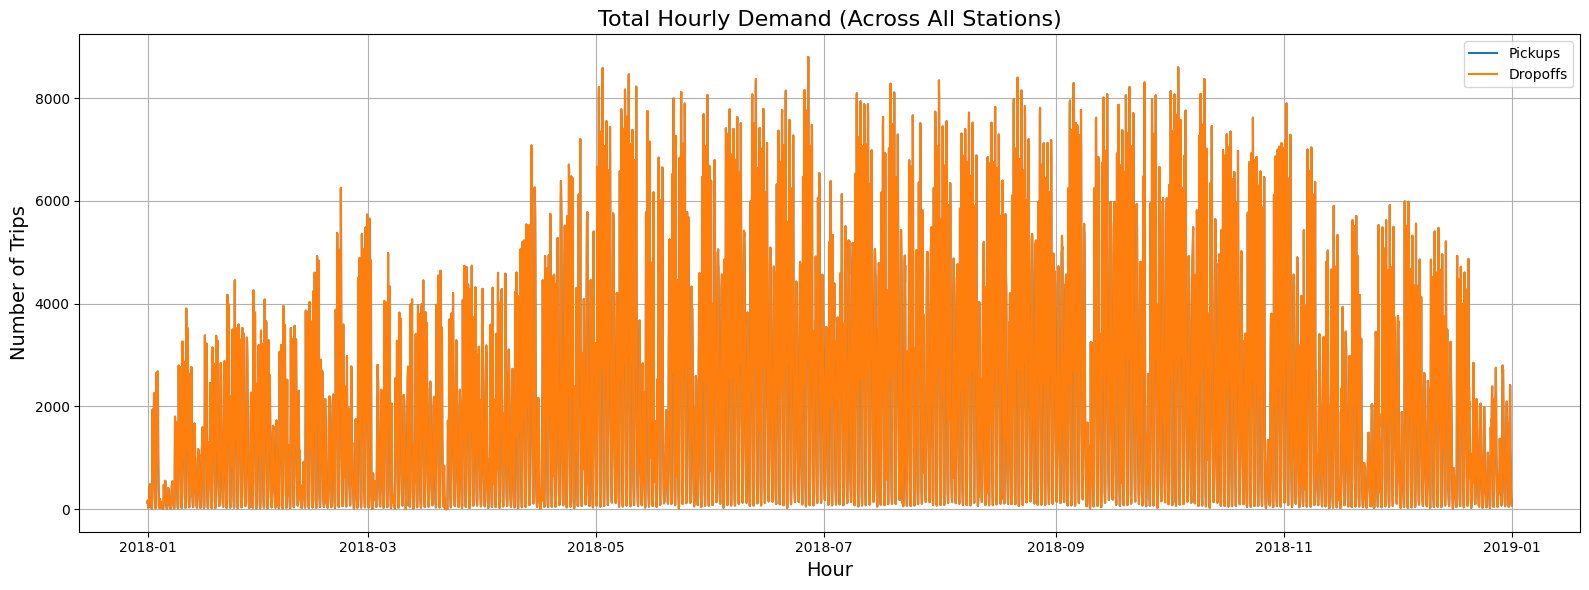

In [66]:
total_hourly = hourly_demand1.groupby("hour")[["pickups", "dropoffs"]].sum()

plt.figure(figsize=(16,6))
plt.plot(total_hourly.index, total_hourly["pickups"], label="Pickups")
plt.plot(total_hourly.index, total_hourly["dropoffs"], label="Dropoffs")

plt.title("Total Hourly Demand (Across All Stations)", fontsize=16)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


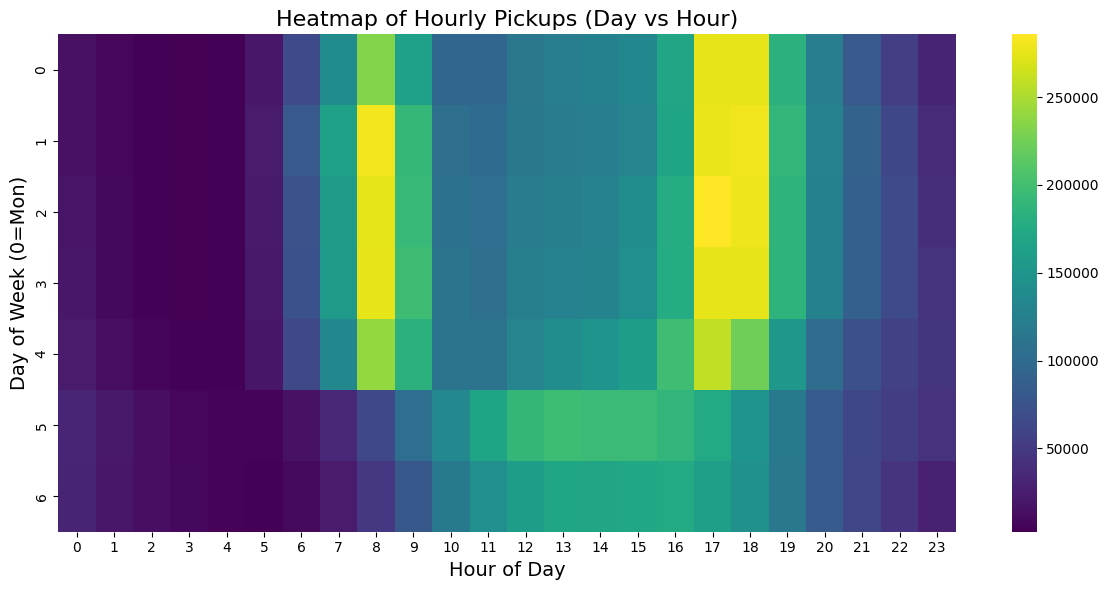

In [67]:
# Create hour-of-day & day-of-week fields
hourly_demand1['hour_of_day'] = hourly_demand1['hour'].dt.hour
hourly_demand1['day_of_week'] = hourly_demand1['hour'].dt.dayofweek  # 0=Monday

# Aggregate pickups by hour & day of week
heatmap_df = hourly_demand1.groupby(["day_of_week", "hour_of_day"])["pickups"].sum().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_df, cmap="viridis")

plt.title("Heatmap of Hourly Pickups (Day vs Hour)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Day of Week (0=Mon)", fontsize=14)
plt.tight_layout()
plt.show()


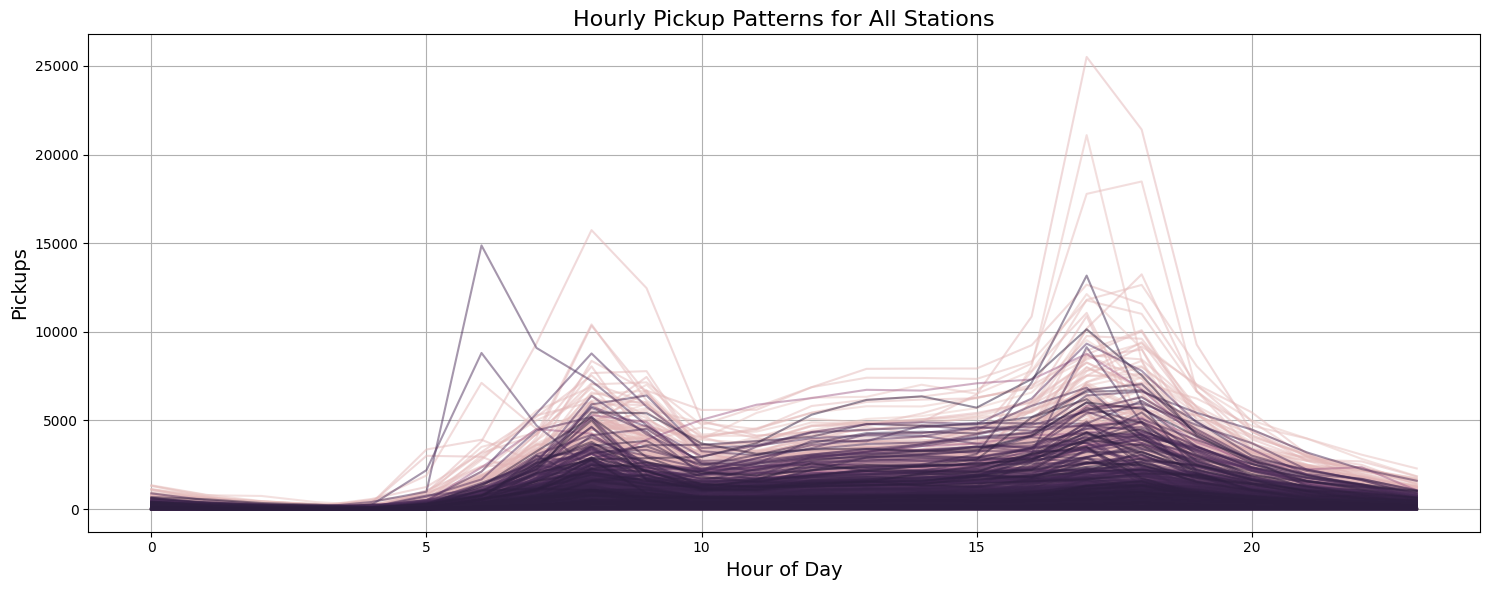

In [68]:
# Average hourly demand per station
station_hour = hourly_demand1.groupby(["station_id", "hour_of_day"])["pickups"].sum().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=station_hour, x="hour_of_day", y="pickups", hue="station_id", legend=False, alpha=0.5)

plt.title("Hourly Pickup Patterns for All Stations", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Pickups", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


Number of unique stations: 846


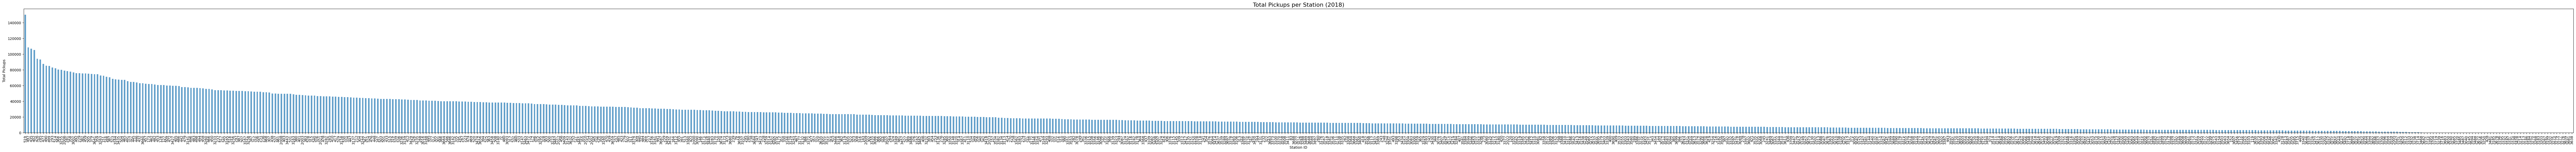

In [69]:
unique_stations = hourly_demand1['station_id'].nunique()
print(f"Number of unique stations: {unique_stations}")

station_totals = (
    hourly_demand1.groupby("station_id")["pickups"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(100,6))
station_totals.plot(kind='bar', alpha=0.7)

plt.title("Total Pickups per Station (2018)", fontsize=16)
plt.xlabel("Station ID")
plt.ylabel("Total Pickups")
plt.tight_layout()
plt.show()


### 12.2 Spatial Clustering of Stations

In [70]:
start_meta = df.groupby("start_station_id")[
    ["start_station_latitude", "start_station_longitude"]
].mean().reset_index().rename(columns={
    "start_station_id": "station_id",
    "start_station_latitude": "lat",
    "start_station_longitude": "lon"
})

end_meta = df.groupby("end_station_id")[
    ["end_station_latitude", "end_station_longitude"]
].mean().reset_index().rename(columns={
    "end_station_id": "station_id",
    "end_station_latitude": "lat",
    "end_station_longitude": "lon"
})

# Combine both tables
stations_meta = pd.concat([start_meta, end_meta], ignore_index=True)

# If the same station appears in both start & end tables, take average again
stations_meta = stations_meta.groupby("station_id")[["lat", "lon"]].mean().reset_index()

print("Number of unique stations:", len(stations_meta))
stations_meta.head()

Number of unique stations: 846


station_id        lat        lon
0        72.0  40.767272 -73.993929
1        79.0  40.719116 -74.006667
2        82.0  40.711174 -74.000165
3        83.0  40.683826 -73.976323
4       119.0  40.696089 -73.978034

In [71]:
stations_meta = stations_meta[
    (stations_meta['lat'] > 40.4) &
    (stations_meta['lat'] < 41) &
    (stations_meta['lon'] > -74.1) &
    (stations_meta['lon'] < -73.7)
]

N_CLUSTERS = 25   # you can choose any number >= 20

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init='auto'
)

stations_meta["cluster"] = kmeans.fit_predict(stations_meta[["lat", "lon"]])

stations_meta.head()

station_id        lat        lon  cluster
0        72.0  40.767272 -73.993929        1
1        79.0  40.719116 -74.006667        9
2        82.0  40.711174 -74.000165        9
3        83.0  40.683826 -73.976323       16
4       119.0  40.696089 -73.978034       16

In [72]:
# Merge clusters back into hourly_demand
hourly_demand1 = hourly_demand1.merge(
    stations_meta[["station_id", "cluster"]],
    on="station_id",
    how="left"
)
hourly_demand1

station_id                hour  pickups  dropoffs  hour_of_day  \
0                72 2018-01-01 00:00:00        0         0            0   
1                72 2018-01-01 01:00:00        0         0            1   
2                72 2018-01-01 02:00:00        0         0            2   
3                72 2018-01-01 03:00:00        0         0            3   
4                72 2018-01-01 04:00:00        0         0            4   
...             ...                 ...      ...       ...          ...   
7410955        3721 2018-12-31 19:00:00        0         0           19   
7410956        3721 2018-12-31 20:00:00        0         0           20   
7410957        3721 2018-12-31 21:00:00        0         0           21   
7410958        3721 2018-12-31 22:00:00        0         0           22   
7410959        3721 2018-12-31 23:00:00        0         0           23   

         day_of_week  cluster  
0                  0      1.0  
1                  0      1.0  
2                  0      1.0  
3                  0      1.0  
4                  0      1.0  
...              ...      ...  
7410955            0     21.0  
7410956            0     21.0  
7410957            0     21.0  
7410958            0     21.0  
7410959            0     21.0  

[7410960 rows x 7 columns]

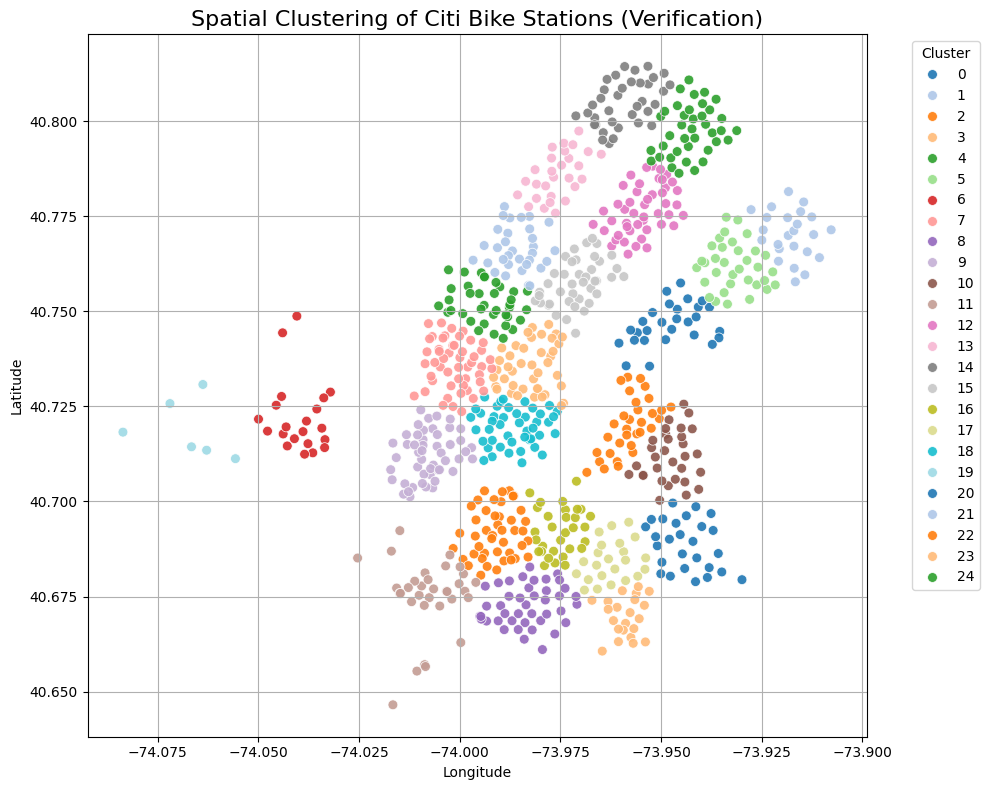

In [73]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=50,
    alpha=0.9
)

plt.title("Spatial Clustering of Citi Bike Stations (Verification)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

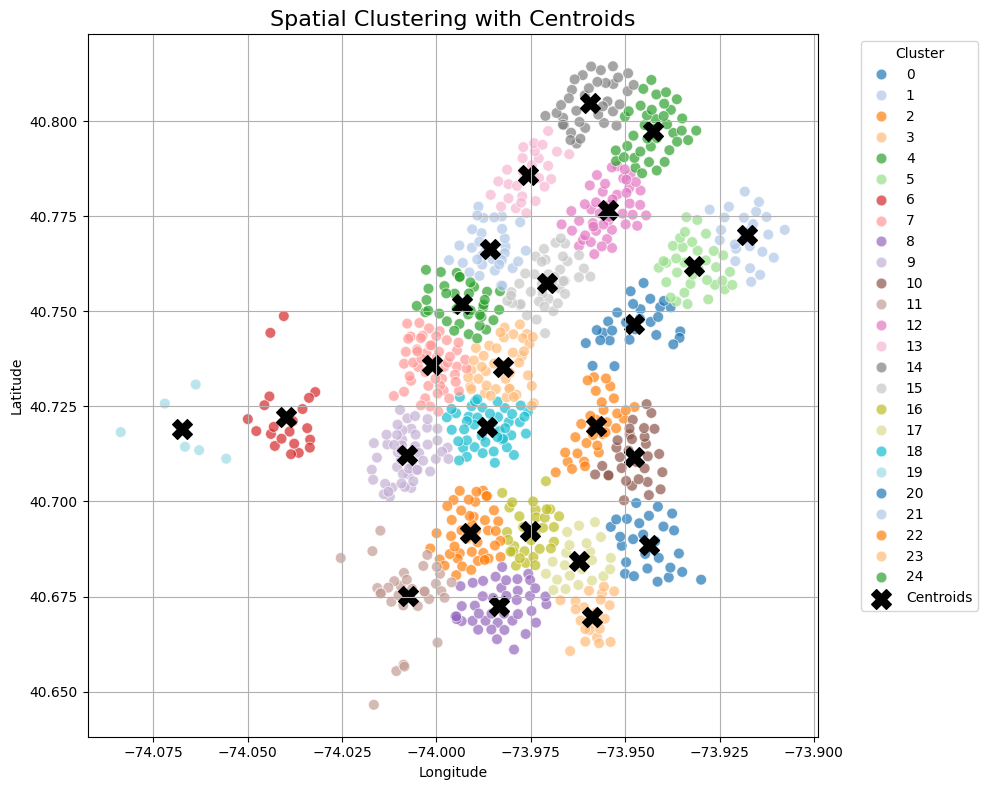

In [74]:
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))

# Plot stations
sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=60,
    alpha=0.7
)

# Plot centroids
plt.scatter(
    centroids[:,1],  # lon
    centroids[:,0],  # lat
    s=200,
    c="black",
    marker="X",
    label="Centroids"
)

plt.title("Spatial Clustering with Centroids", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
# Merge cluster labels to hourly demand
hourly_cluster_demand = hourly_demand1.merge(
    stations_meta[['station_id', 'cluster']],
    on='station_id',
    how='left'
)

hourly_cluster_demand = hourly_cluster_demand.drop(columns=["cluster_y"])
hourly_cluster_demand = hourly_cluster_demand.rename(columns={"cluster_x": "cluster"})
hourly_cluster_demand = hourly_cluster_demand.sort_values(["cluster", "hour"])
hourly_cluster_demand = hourly_cluster_demand.set_index("hour")

hourly_cluster_demand.head()


station_id  pickups  dropoffs  hour_of_day  day_of_week  cluster
hour                                                                        
2018-01-01         373        0         1            0            0      0.0
2018-01-01         437        0         0            0            0      0.0
2018-01-01        3041        0         0            0            0      0.0
2018-01-01        3042        0         0            0            0      0.0
2018-01-01        3043        0         0            0            0      0.0

In [76]:
cluster_ts = (
    hourly_cluster_demand
    .groupby("cluster")
    .resample("h")
    .sum()[["pickups", "dropoffs"]]
    .reset_index()
)
cluster_ts.head()
cluster_ts["hour_of_day"] = cluster_ts["hour"].dt.hour
cluster_ts["day_of_week"] = cluster_ts["hour"].dt.weekday
cluster_ts["month"] = cluster_ts["hour"].dt.month
cluster_ts["day"] = cluster_ts["hour"].dt.day
cluster_ts.head()


C:\Users\UPASANA\AppData\Local\Temp\ipykernel_29768\954190499.py:5: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .sum()[["pickups", "dropoffs"]]


cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0      0.0 2018-01-01 00:00:00        3         2            0            0   
1      0.0 2018-01-01 01:00:00        2         3            1            0   
2      0.0 2018-01-01 02:00:00        2         2            2            0   
3      0.0 2018-01-01 03:00:00        4         6            3            0   
4      0.0 2018-01-01 04:00:00        0         0            4            0   

   month  day  
0      1    1  
1      1    1  
2      1    1  
3      1    1  
4      1    1

In [77]:
train = cluster_ts[cluster_ts["month"] <= 10].reset_index(drop=True)

# VALIDATION: November
val = cluster_ts[(cluster_ts["month"] == 11)].reset_index(drop=True)

# TEST: December
test = cluster_ts[(cluster_ts["month"] == 12)].reset_index(drop=True)

print("Train rows:", len(train))
print("Validation rows:", len(val))
print("Test rows:", len(test))

Train rows: 182400
Validation rows: 18000
Test rows: 18600


In [78]:
baseline = (
    train.groupby(["cluster", "hour_of_day"])
    .agg({
        "pickups": "mean",
        "dropoffs": "mean"
    })
    .reset_index()
    .rename(columns={
        "pickups": "baseline_pickups",
        "dropoffs": "baseline_dropoffs"
    })
)

baseline.head()


cluster  hour_of_day  baseline_pickups  baseline_dropoffs
0      0.0            0          6.177632          10.865132
1      0.0            1          3.947368           5.947368
2      0.0            2          2.407895           3.250000
3      0.0            3          1.618421           2.082237
4      0.0            4          1.253289           1.532895

In [79]:
val_pred = val.merge(
    baseline,
    on=["cluster", "hour_of_day"],
    how="left"
)

# Fill missing predictions with global mean if needed
val_pred["baseline_pickups"].fillna(train["pickups"].mean(), inplace=True)
val_pred["baseline_dropoffs"].fillna(train["dropoffs"].mean(), inplace=True)

val_pred.head(20)

C:\Users\UPASANA\AppData\Local\Temp\ipykernel_29768\4173580317.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  val_pred["baseline_pickups"].fillna(train["pickups"].mean(), inplace=True)
C:\Users\UPASANA\AppData\Local\Temp\ipykernel_29768\4173580317.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0       0.0 2018-11-01 00:00:00        8        16            0            3   
1       0.0 2018-11-01 01:00:00        5        14            1            3   
2       0.0 2018-11-01 02:00:00        3         3            2            3   
3       0.0 2018-11-01 03:00:00        0         2            3            3   
4       0.0 2018-11-01 04:00:00        1         3            4            3   
5       0.0 2018-11-01 05:00:00        7         2            5            3   
6       0.0 2018-11-01 06:00:00       26        20            6            3   
7       0.0 2018-11-01 07:00:00       35        24            7            3   
8       0.0 2018-11-01 08:00:00       77        60            8            3   
9       0.0 2018-11-01 09:00:00       59        25            9            3   
10      0.0 2018-11-01 10:00:00       30        13           10            3   
11      0.0 2018-11-01 11:00:00       26        13           11            3   
12      0.0 2018-11-01 12:00:00       38        14           12            3   
13      0.0 2018-11-01 13:00:00       24        21           13            3   
14      0.0 2018-11-01 14:00:00       25        20           14            3   
15      0.0 2018-11-01 15:00:00       29        20           15            3   
16      0.0 2018-11-01 16:00:00       24        25           16            3   
17      0.0 2018-11-01 17:00:00       39        43           17            3   
18      0.0 2018-11-01 18:00:00       45        55           18            3   
19      0.0 2018-11-01 19:00:00       32        67           19            3   

    month  day  baseline_pickups  baseline_dropoffs  
0      11    1          6.177632          10.865132  
1      11    1          3.947368           5.947368  
2      11    1          2.407895           3.250000  
3      11    1          1.618421           2.082237  
4      11    1          1.253289           1.532895  
5      11    1          2.605263           1.740132  
6      11    1         10.703947           7.934211  
7      11    1         23.371711          16.138158  
8      11    1         43.677632          26.697368  
9      11    1         36.141447          20.842105  
10     11    1         24.460526          14.851974  
11     11    1         26.233553          17.309211  
12     11    1         25.651316          19.782895  
13     11    1         26.496711          21.075658  
14     11    1         25.881579          22.411184  
15     11    1         25.039474          23.013158  
16     11    1         24.917763          27.832237  
17     11    1         30.825658          36.611842  
18     11    1         35.819079          46.552632  
19     11    1         30.342105          41.569079

In [80]:
mae_pu = mean_absolute_error(val_pred["pickups"], val_pred["baseline_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val_pred["pickups"], val_pred["baseline_pickups"]))

# Dropoffs
mae_do = mean_absolute_error(val_pred["dropoffs"], val_pred["baseline_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val_pred["dropoffs"], val_pred["baseline_dropoffs"]))

print("Baseline Pickups MAE:", mae_pu)
print("Baseline Pickups RMSE:", rmse_pu)
print("Baseline Dropoffs MAE:", mae_do)
print("Baseline Dropoffs RMSE:", rmse_do)

Baseline Pickups MAE: 33.315243421052635
Baseline Pickups RMSE: 68.60659480658796
Baseline Dropoffs MAE: 33.16328764619883
Baseline Dropoffs RMSE: 69.30457577221321


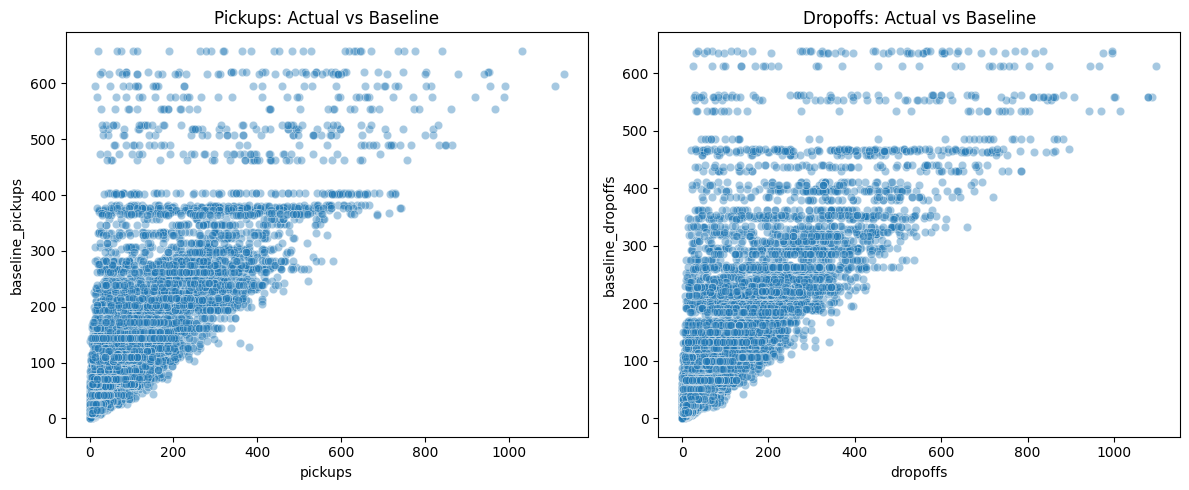

In [81]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=val_pred["pickups"], y=val_pred["baseline_pickups"], alpha=0.4)
plt.title("Pickups: Actual vs Baseline")

plt.subplot(1,2,2)
sns.scatterplot(x=val_pred["dropoffs"], y=val_pred["baseline_dropoffs"], alpha=0.4)
plt.title("Dropoffs: Actual vs Baseline")

plt.tight_layout()
plt.show()


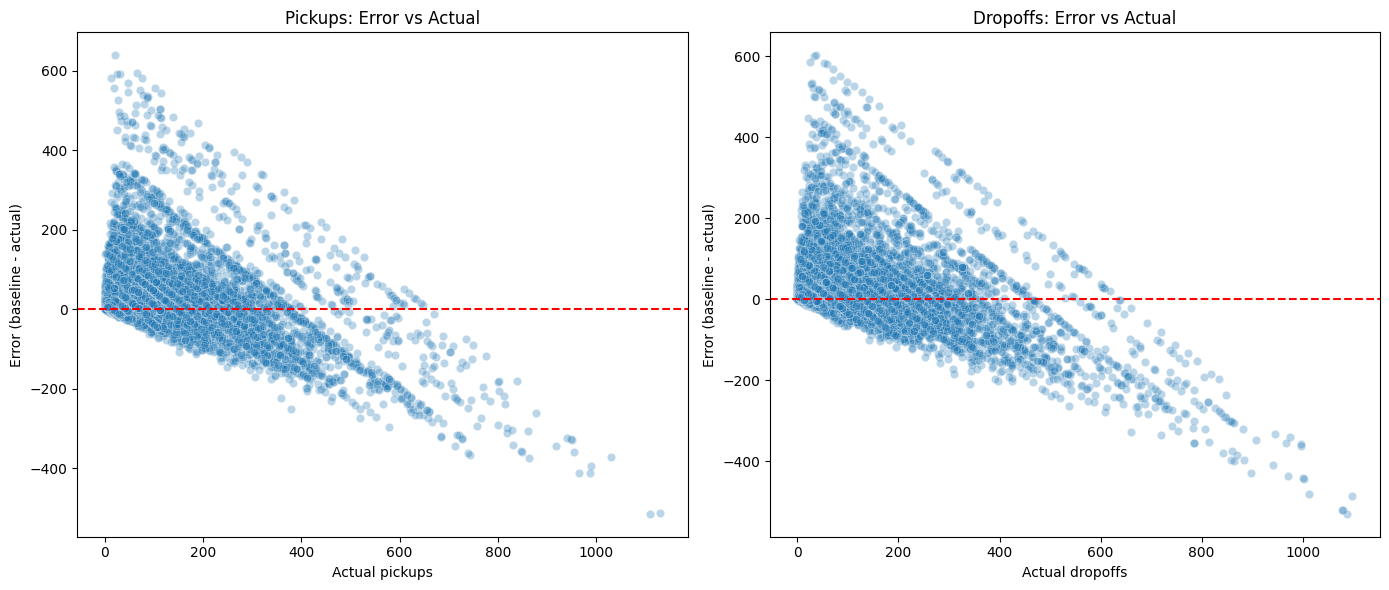

In [82]:
val_pred["error_pickups"] = val_pred["baseline_pickups"] - val_pred["pickups"]
val_pred["error_dropoffs"] = val_pred["baseline_dropoffs"] - val_pred["dropoffs"]

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.scatterplot(x=val_pred["pickups"], y=val_pred["error_pickups"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Pickups: Error vs Actual")
plt.xlabel("Actual pickups")
plt.ylabel("Error (baseline - actual)")

plt.subplot(1,2,2)
sns.scatterplot(x=val_pred["dropoffs"], y=val_pred["error_dropoffs"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Dropoffs: Error vs Actual")
plt.xlabel("Actual dropoffs")
plt.ylabel("Error (baseline - actual)")
plt.tight_layout()
plt.show()


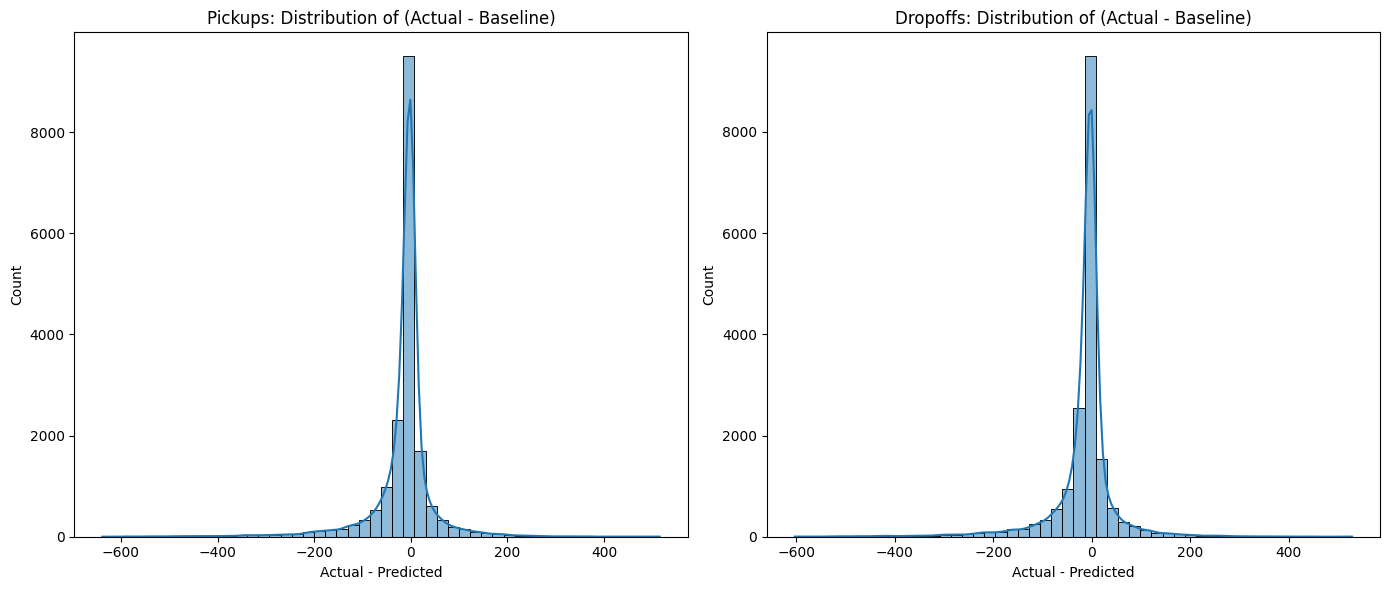

In [83]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(val_pred["pickups"] - val_pred["baseline_pickups"], bins=50, kde=True)
plt.title("Pickups: Distribution of (Actual - Baseline)")
plt.xlabel("Actual - Predicted")

plt.subplot(1,2,2)
sns.histplot(val_pred["dropoffs"] - val_pred["baseline_dropoffs"], bins=50, kde=True)
plt.title("Dropoffs: Distribution of (Actual - Baseline)")
plt.xlabel("Actual - Predicted")

plt.tight_layout()
plt.show()


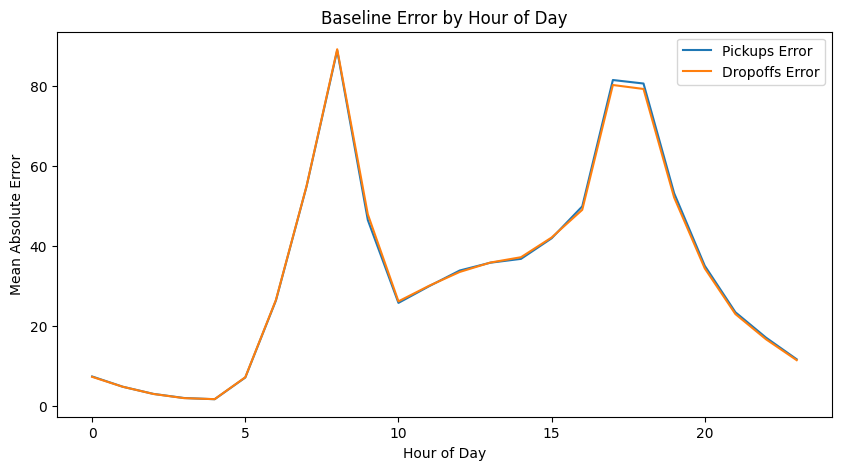

In [84]:
hourly_err = (
    val_pred
    .assign(err_pu = abs(val_pred["baseline_pickups"] - val_pred["pickups"]),
            err_do = abs(val_pred["baseline_dropoffs"] - val_pred["dropoffs"]))
    .groupby("hour_of_day")[["err_pu", "err_do"]]
    .mean()
)

plt.figure(figsize=(10,5))
plt.plot(hourly_err.index, hourly_err["err_pu"], label="Pickups Error")
plt.plot(hourly_err.index, hourly_err["err_do"], label="Dropoffs Error")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.title("Baseline Error by Hour of Day")
plt.legend()
plt.show()


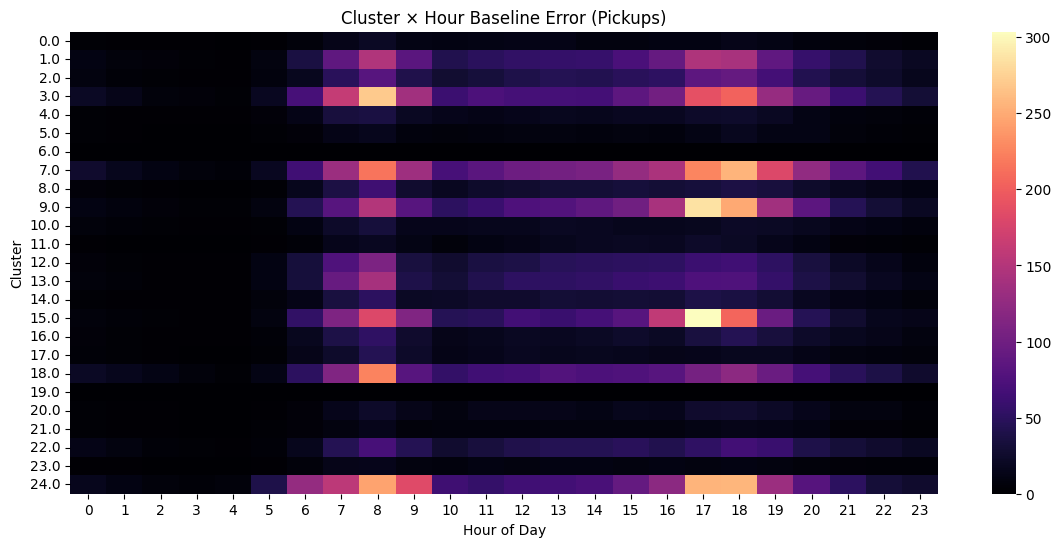

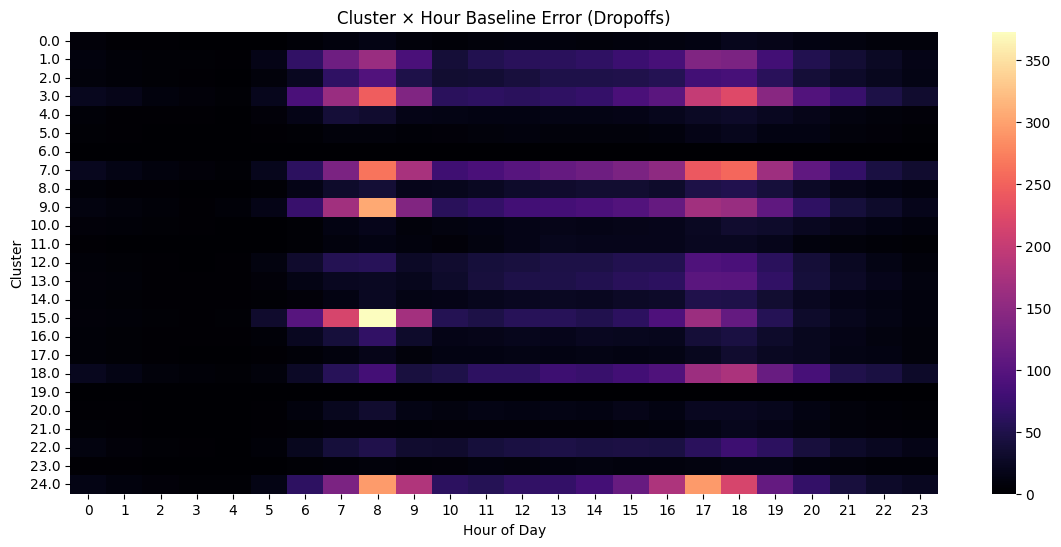

In [85]:


val_pred["abs_error_pu"] = np.abs(val_pred["baseline_pickups"] - val_pred["pickups"])
val_pred["abs_error_do"] = np.abs(val_pred["baseline_dropoffs"] - val_pred["dropoffs"])

heat = val_pred.groupby(["cluster", "hour_of_day"])[["abs_error_pu", "abs_error_do"]].mean()

plt.figure(figsize=(14,6))
sns.heatmap(heat["abs_error_pu"].unstack(), cmap="magma")
plt.title("Cluster × Hour Baseline Error (Pickups)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()

plt.figure(figsize=(14,6))
sns.heatmap(heat["abs_error_do"].unstack(), cmap="magma")
plt.title("Cluster × Hour Baseline Error (Dropoffs)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


In [86]:
df_long = val_pred.copy()

# Melt pickups
df_pick = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["pickups", "baseline_pickups"],
    var_name="type",
    value_name="value"
)
df_pick["metric"] = "pickups"

# Melt dropoffs
df_drop = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["dropoffs", "baseline_dropoffs"],
    var_name="type",
    value_name="value"
)
df_drop["metric"] = "dropoffs"

# Combine
df_melt = pd.concat([df_pick, df_drop], ignore_index=True)
df_melt

cluster                hour               type       value    metric
0          0.0 2018-11-01 00:00:00            pickups    8.000000   pickups
1          0.0 2018-11-01 01:00:00            pickups    5.000000   pickups
2          0.0 2018-11-01 02:00:00            pickups    3.000000   pickups
3          0.0 2018-11-01 03:00:00            pickups    0.000000   pickups
4          0.0 2018-11-01 04:00:00            pickups    1.000000   pickups
...        ...                 ...                ...         ...       ...
71995     24.0 2018-11-30 19:00:00  baseline_dropoffs  285.322368  dropoffs
71996     24.0 2018-11-30 20:00:00  baseline_dropoffs  185.549342  dropoffs
71997     24.0 2018-11-30 21:00:00  baseline_dropoffs  131.898026  dropoffs
71998     24.0 2018-11-30 22:00:00  baseline_dropoffs   98.815789  dropoffs
71999     24.0 2018-11-30 23:00:00  baseline_dropoffs   66.875000  dropoffs

[72000 rows x 5 columns]

Index(['cluster', 'hour', 'pickups', 'dropoffs', 'hour_of_day', 'day_of_week',
       'month', 'day', 'baseline_pickups', 'baseline_dropoffs',
       'error_pickups', 'error_dropoffs', 'abs_error_pu', 'abs_error_do'],
      dtype='object')


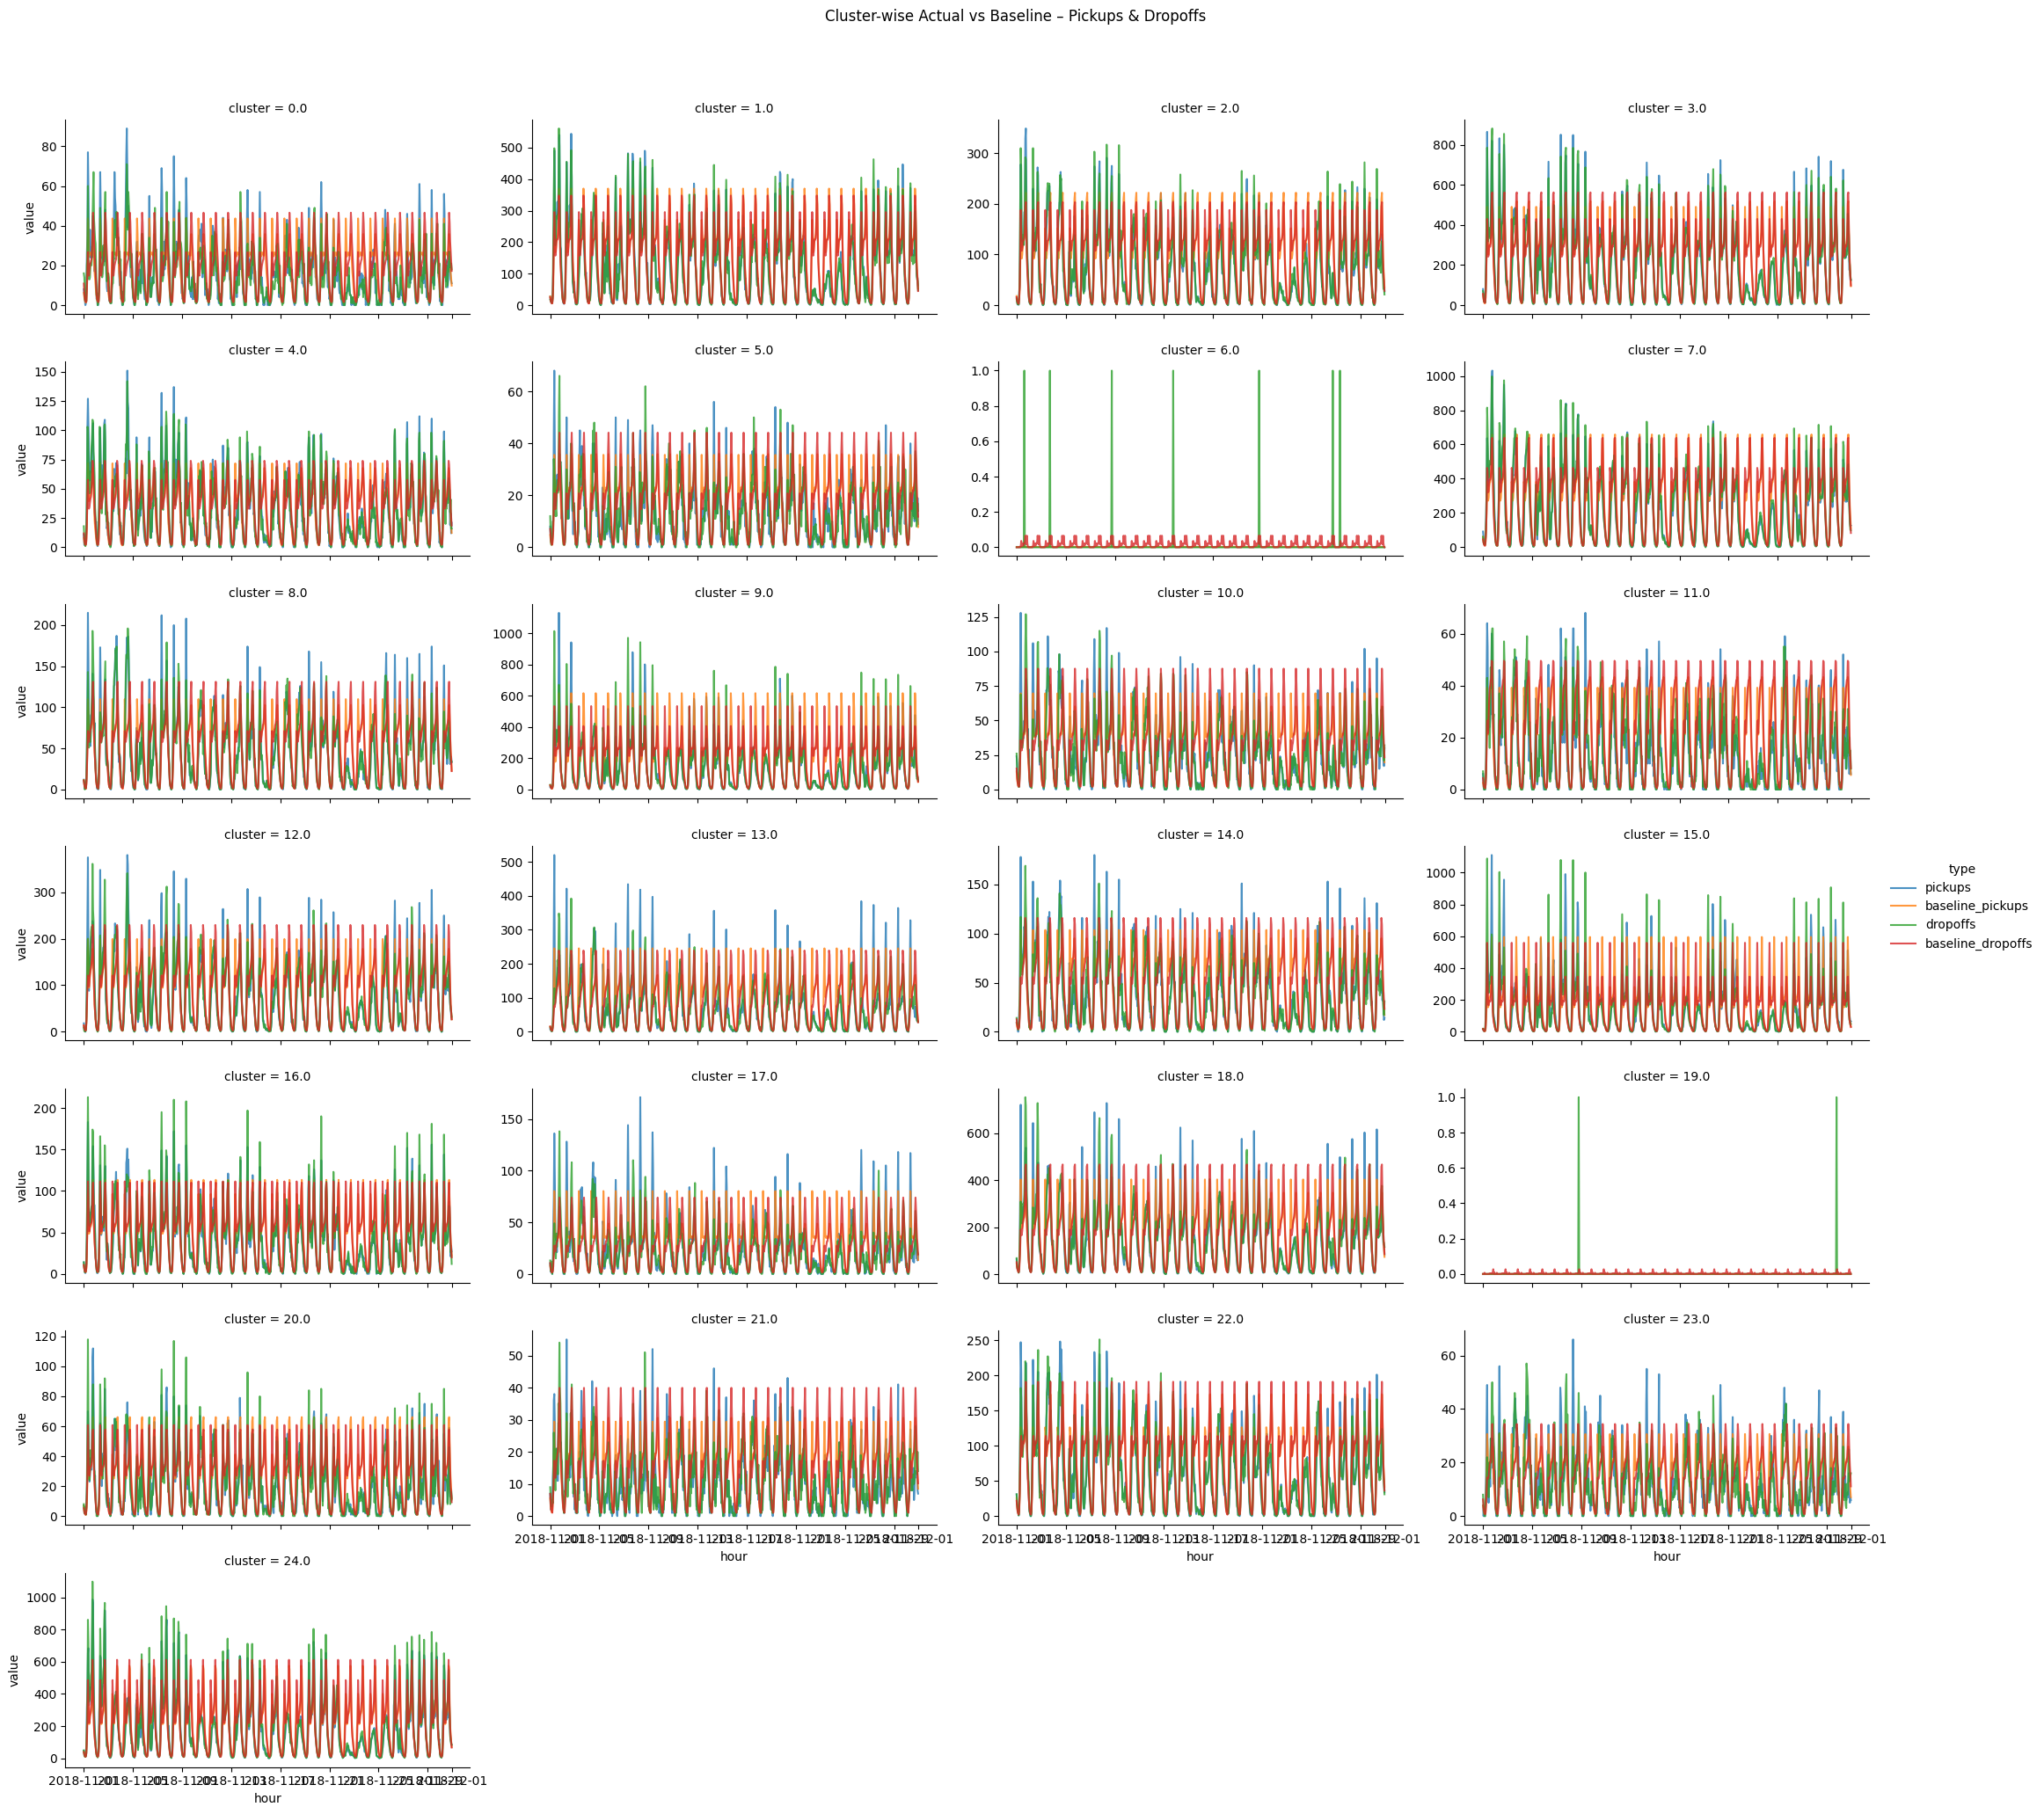

In [87]:
df_long = val_pred.copy()
print(df_long.columns)

df_long = val_pred.copy()

df_pick = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["pickups", "baseline_pickups"],
    var_name="type",
    value_name="value"
)
df_pick["metric"] = "pickups"

df_drop = df_long.melt(
    id_vars=["cluster", "hour"],
    value_vars=["dropoffs", "baseline_dropoffs"],
    var_name="type",
    value_name="value"
)
df_drop["metric"] = "dropoffs"
df_melt = pd.concat([df_pick, df_drop], ignore_index=True)

# Small multiple plots
g = sns.FacetGrid(
    df_melt,
    col="cluster",
    col_wrap=4,
    height=3,
    aspect=1.8,
    sharey=False,
    hue="type"     # actual vs baseline
)

g.map(sns.lineplot, "hour", "value", alpha=0.8)
g.add_legend()

plt.subplots_adjust(top=0.92)
g.fig.suptitle("Cluster-wise Actual vs Baseline – Pickups & Dropoffs")
plt.show()

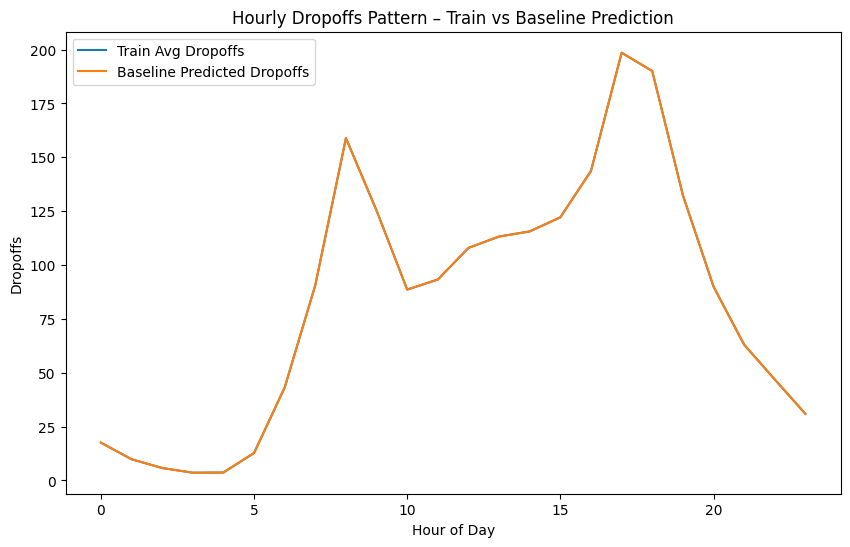

In [88]:
plt.figure(figsize=(10,6))

# Train hourly average dropoffs
sns.lineplot(
    data=train.groupby("hour_of_day")["dropoffs"].mean().reset_index(),
    x="hour_of_day", 
    y="dropoffs", 
    label="Train Avg Dropoffs"
)

# Baseline predicted dropoffs
sns.lineplot(
    data=val_pred.groupby("hour_of_day")["baseline_dropoffs"].mean().reset_index(),
    x="hour_of_day", 
    y="baseline_dropoffs", 
    label="Baseline Predicted Dropoffs"
)

plt.title("Hourly Dropoffs Pattern – Train vs Baseline Prediction")
plt.xlabel("Hour of Day")
plt.ylabel("Dropoffs")
plt.legend()
plt.show()


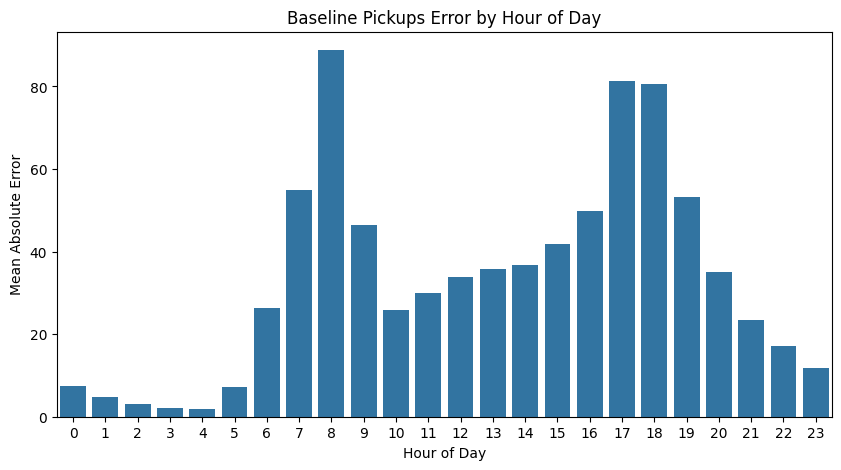

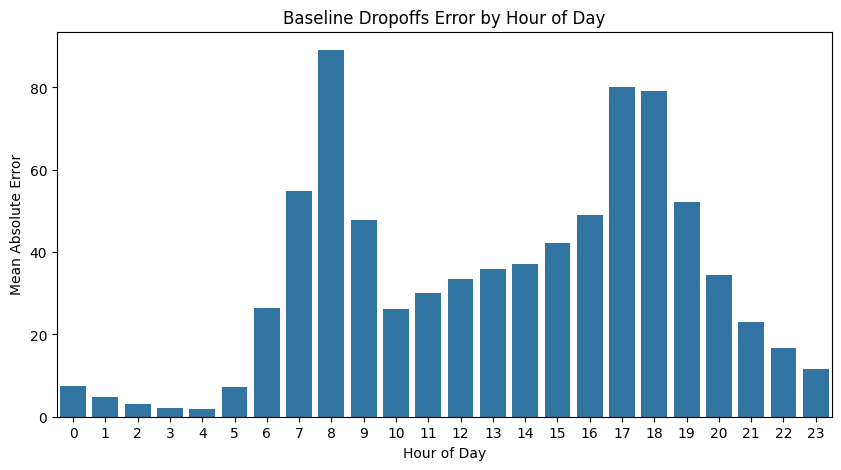

In [89]:
# Baseline weakness: pickups

val_pred["abs_error_pickups"] = (
    val_pred["pickups"] - val_pred["baseline_pickups"]
).abs()

df_err = (
    val_pred.groupby("hour_of_day")["abs_error_pickups"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=df_err, x="hour_of_day", y="abs_error_pickups")
plt.title("Baseline Pickups Error by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.show()

val_pred["abs_error_dropoffs"] = (
    val_pred["dropoffs"] - val_pred["baseline_dropoffs"]
).abs()

df_err_do = (
    val_pred.groupby("hour_of_day")["abs_error_dropoffs"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=df_err_do, x="hour_of_day", y="abs_error_dropoffs")
plt.title("Baseline Dropoffs Error by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error")
plt.show()



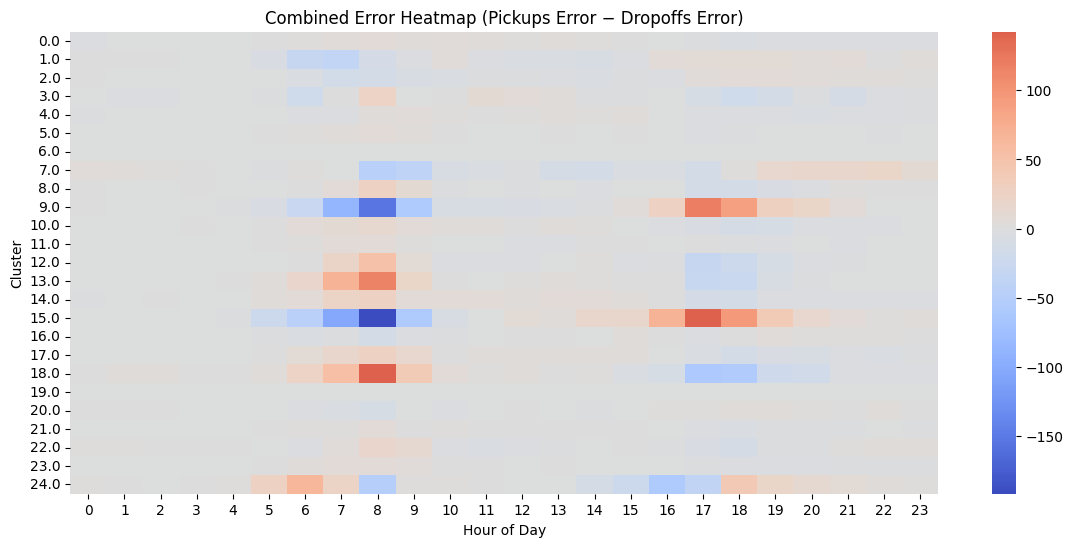

In [90]:
val_pred["combined_error"] = val_pred["abs_error_pu"] - val_pred["abs_error_do"]

heat_combined = (
    val_pred.groupby(["cluster", "hour_of_day"])["combined_error"]
            .mean()
            .reset_index()
            .pivot(index="cluster", columns="hour_of_day", values="combined_error")
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_combined, 
    cmap="coolwarm",     # red = worse for dropoffs, blue = worse for pickups
    center=0,            # zero difference is white
    linewidths=0
)
plt.title("Combined Error Heatmap (Pickups Error − Dropoffs Error)")
plt.xlabel("Hour of Day")
plt.ylabel("Cluster")
plt.show()


# Random Forest Model

In [91]:
train["lag1_pu"] = train.groupby("cluster")["pickups"].shift(1)
val["lag1_pu"]   = val.groupby("cluster")["pickups"].shift(1)
test["lag1_pu"]  = test.groupby("cluster")["pickups"].shift(1)

# Lag for dropoffs
train["lag1_do"] = train.groupby("cluster")["dropoffs"].shift(1)
val["lag1_do"]   = val.groupby("cluster")["dropoffs"].shift(1)
test["lag1_do"]  = test.groupby("cluster")["dropoffs"].shift(1)

# Fill NA
train.fillna(0, inplace=True)
val.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [92]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

feature_cols = [
    "cluster",
    "hour_of_day",
    "day_of_week",
    "month",
    "lag1_pu",
    "lag1_do"
]

X_train = train[feature_cols]
y_train = train[["pickups", "dropoffs"]]

multi_rf = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        n_jobs=-1,
        random_state=42
    )
)

multi_rf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=15,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [93]:
val[["pred_pickups", "pred_dropoffs"]] = multi_rf.predict(val[feature_cols])
test[["pred_pickups", "pred_dropoffs"]] = multi_rf.predict(test[feature_cols])


In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Pickups
mae_pu = mean_absolute_error(val["pickups"], val["pred_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val["pickups"], val["pred_pickups"]))

# Dropoffs
mae_do = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

print("RF Multi-out Pickups MAE:", mae_pu)
print("RF Multi-out Pickups RMSE:", rmse_pu)
print("RF Multi-out Dropoffs MAE:", mae_do)
print("RF Multi-out Dropoffs RMSE:", rmse_do)


RF Multi-out Pickups MAE: 10.926145277087922
RF Multi-out Pickups RMSE: 21.757517291091695
RF Multi-out Dropoffs MAE: 11.019269526384038
RF Multi-out Dropoffs RMSE: 22.001166729939378


In [95]:
print([col for col in train.columns if 'lag' in col])



['lag1_pu', 'lag1_do']


In [99]:
from xgboost import XGBRegressor
feature_cols = ["cluster", "hour_of_day", "day_of_week", "month", "lag1_pu", "lag1_do"]
xgb_pu = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_pu.fit(
    train[feature_cols], train["pickups"],
    eval_set=[(val[feature_cols], val["pickups"])],
    #early_stopping_rounds=50,
    verbose=False
)
xgb_do = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_do.fit(
    train[feature_cols], train["dropoffs"],
    eval_set=[(val[feature_cols], val["dropoffs"])],
    #early_stopping_rounds=50,
    verbose=False
)
val["pred_pickups"]  = xgb_pu.predict(val[feature_cols])
val["pred_dropoffs"] = xgb_do.predict(val[feature_cols])


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
mae_pu = mean_absolute_error(val["pickups"], val["pred_pickups"])
rmse_pu = np.sqrt(mean_squared_error(val["pickups"], val["pred_pickups"]))

mae_do = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

val.head()

print("XGBoost Pickups MAE:", mae_pu)
print("XGBoost Pickups RMSE:", rmse_pu)
print("XGBoost Dropoffs MAE:", mae_do)
print("XGBoost Dropoffs RMSE:", rmse_do)
val.head(100)

XGBoost Pickups MAE: 11.250357627868652
XGBoost Pickups RMSE: 22.1634043346057
XGBoost Dropoffs MAE: 11.49845027923584
XGBoost Dropoffs RMSE: 22.940095593520176


cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0       0.0 2018-11-01 00:00:00        8        16            0            3   
1       0.0 2018-11-01 01:00:00        5        14            1            3   
2       0.0 2018-11-01 02:00:00        3         3            2            3   
3       0.0 2018-11-01 03:00:00        0         2            3            3   
4       0.0 2018-11-01 04:00:00        1         3            4            3   
..      ...                 ...      ...       ...          ...          ...   
95      0.0 2018-11-04 23:00:00       10         9           23            6   
96      0.0 2018-11-05 00:00:00        4         8            0            0   
97      0.0 2018-11-05 01:00:00        3         3            1            0   
98      0.0 2018-11-05 02:00:00        1         3            2            0   
99      0.0 2018-11-05 03:00:00        0         0            3            0   

    month  day  lag1_pu  lag1_do  pred_pickups  pred_dropoffs  
0      11    1      0.0      0.0      1.744140       2.485216  
1      11    1      8.0     16.0      4.531454       7.734230  
2      11    1      5.0     14.0      3.775480       6.460764  
3      11    1      3.0      3.0      1.539305       2.147145  
4      11    1      0.0      2.0      1.811248       1.789642  
..    ...  ...      ...      ...           ...            ...  
95     11    4     14.0     25.0     11.401090      16.187122  
96     11    5     10.0      9.0      4.445632       7.546608  
97     11    5      4.0      8.0      2.515911       4.803180  
98     11    5      3.0      3.0      1.382467       2.364067  
99     11    5      1.0      3.0      1.004067       1.882747  

[100 rows x 12 columns]

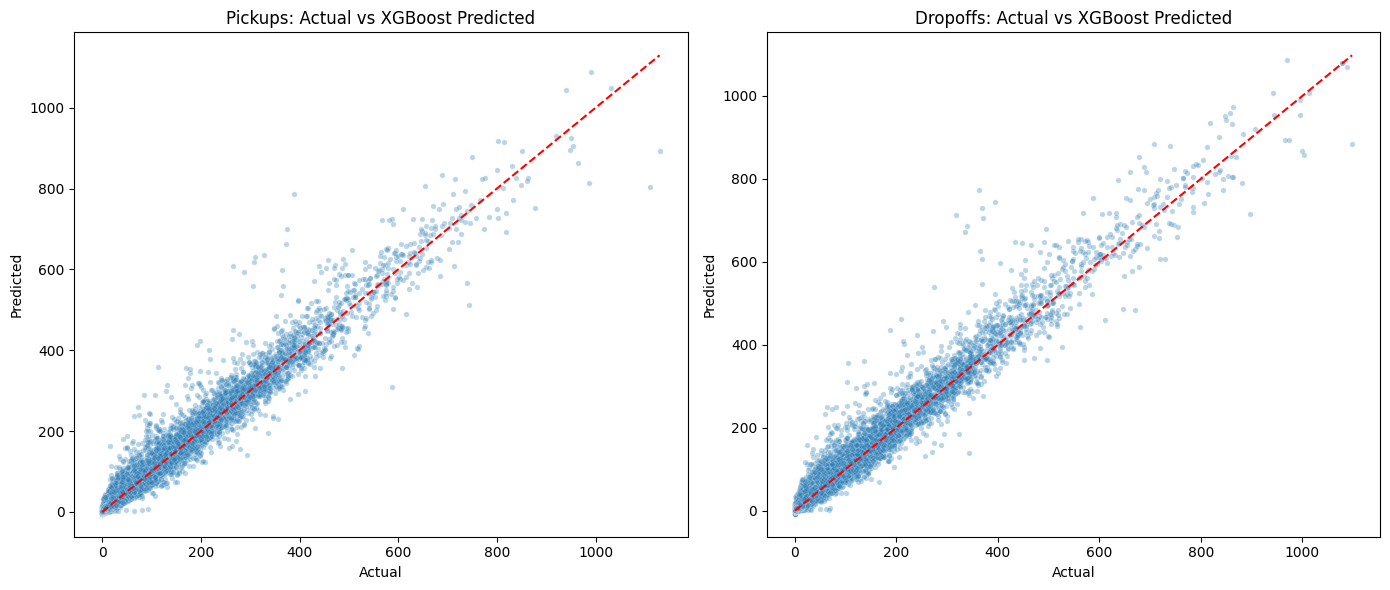

In [ ]:
plt.figure(figsize=(14,6))

# PICKUPS
plt.subplot(1,2,1)
sns.scatterplot(x=val["pickups"], y=val["pred_pickups"], alpha=0.3, s=15)
plt.plot([0, max(val["pickups"])], [0, max(val["pickups"])], 'r--')
plt.title("Pickups: Actual vs XGBoost Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# DROPOFFS
plt.subplot(1,2,2)
sns.scatterplot(x=val["dropoffs"], y=val["pred_dropoffs"], alpha=0.3, s=15)
plt.plot([0, max(val["dropoffs"])], [0, max(val["dropoffs"])], 'r--')
plt.title("Dropoffs: Actual vs XGBoost Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

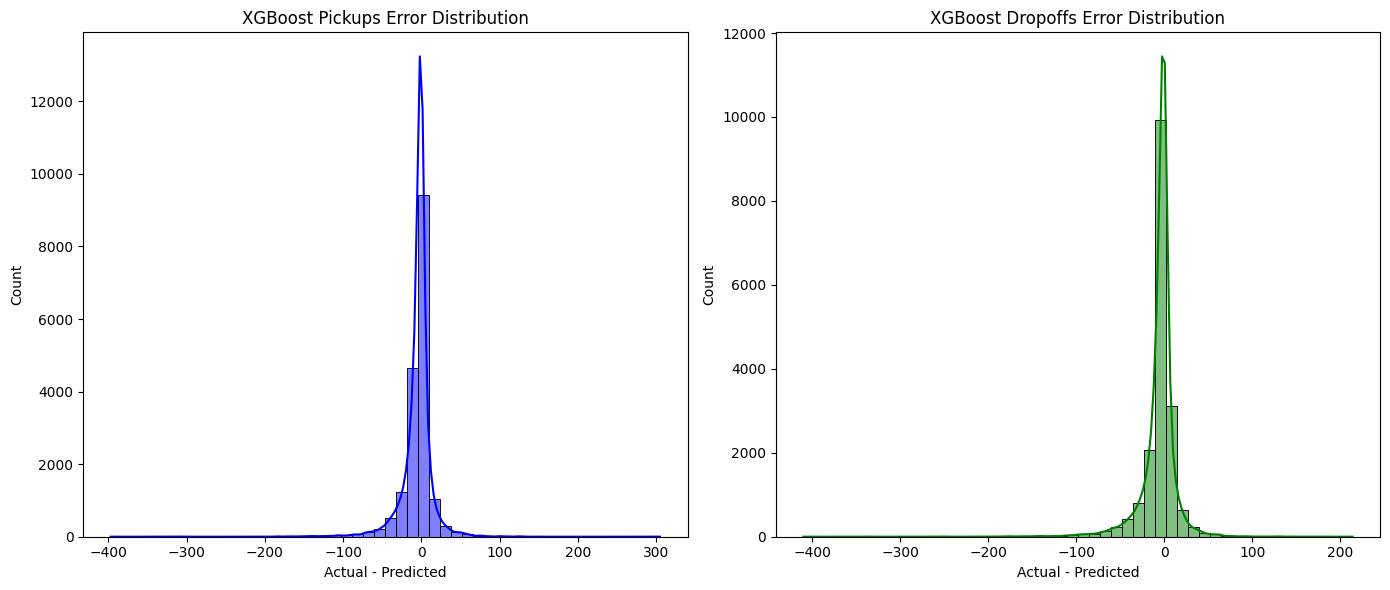

In [ ]:
plt.figure(figsize=(14,6))

# PICKUPS
plt.subplot(1,2,1)
sns.histplot(val["pickups"] - val["pred_pickups"], bins=50, kde=True, color="blue")
plt.title("XGBoost Pickups Error Distribution")
plt.xlabel("Actual - Predicted")

# DROPOFFS
plt.subplot(1,2,2)
sns.histplot(val["dropoffs"] - val["pred_dropoffs"], bins=50, kde=True, color="green")
plt.title("XGBoost Dropoffs Error Distribution")
plt.xlabel("Actual - Predicted")

plt.tight_layout()
plt.show()


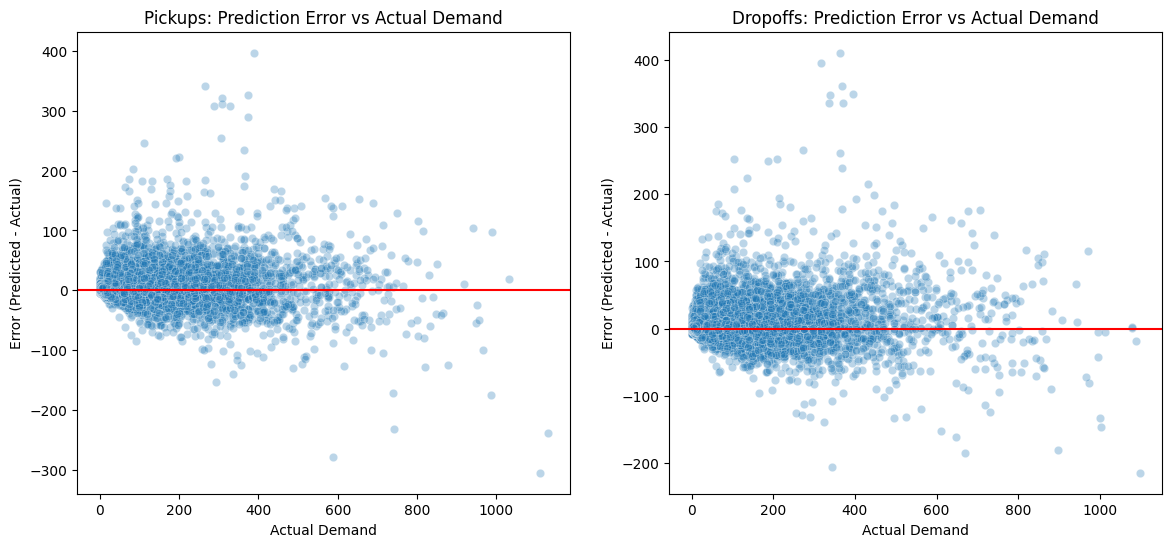

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.scatterplot(
    x=val["pickups"],
    y=val["pred_pickups"] - val["pickups"],
    alpha=0.3
)
plt.axhline(0, color="red")
plt.title("Pickups: Prediction Error vs Actual Demand")
plt.xlabel("Actual Demand")
plt.ylabel("Error (Predicted - Actual)")

plt.subplot(1,2,2)
sns.scatterplot(
    x=val["dropoffs"],
    y=val["pred_dropoffs"] - val["dropoffs"],
    alpha=0.3
)
plt.axhline(0, color="red")
plt.title("Dropoffs: Prediction Error vs Actual Demand")
plt.xlabel("Actual Demand")
plt.ylabel("Error (Predicted - Actual)")
plt.show()


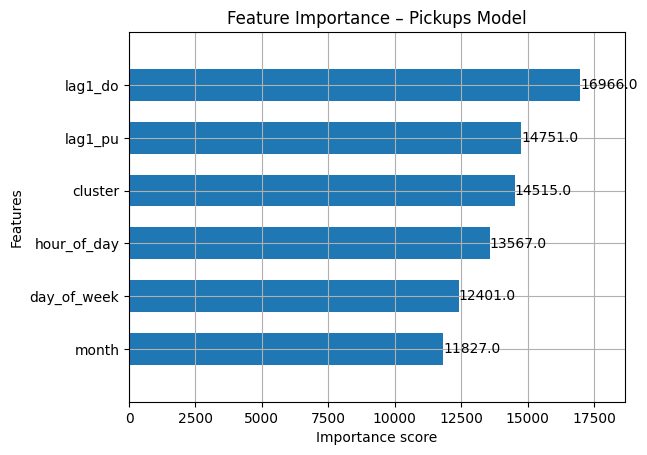

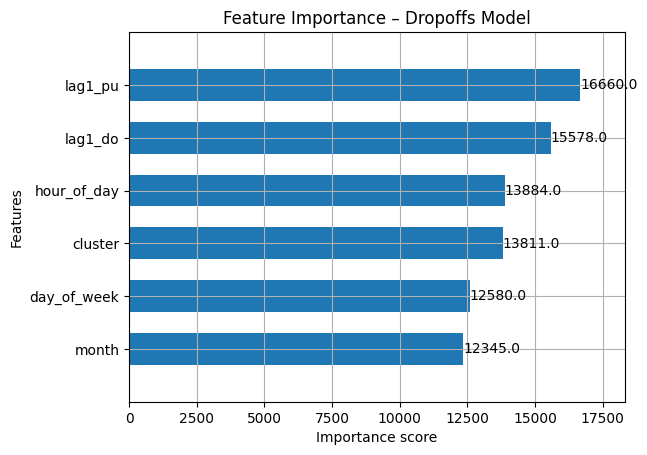

In [ ]:
import xgboost as xgb
xgb.plot_importance(xgb_pu, height=0.6)
plt.title("Feature Importance – Pickups Model")
plt.show()

xgb.plot_importance(xgb_do, height=0.6)
plt.title("Feature Importance – Dropoffs Model")
plt.show()

In [ ]:
feature_cols = ["cluster", "hour_of_day", "day_of_week", "month", 
                "lag1_pu", "lag1_do"]
def forecast_next_24h(cluster_id, last_day_df, xgb_pu, xgb_do):
    """
    last_day_df: last day of available data (Nov 30 for validation, Dec 31 for test)
    xgb_pu: trained XGBoost pickups model
    xgb_do: trained XGBoost dropoffs model
    """
    
    # Extract last known values
    last_row = last_day_df[last_day_df["cluster"] == cluster_id].sort_values("hour").iloc[-1]

    lag_pu = last_row["pickups"]
    lag_do = last_row["dropoffs"]
    
    # Start from the next day at 00:00
    next_day_start = last_row["hour"].replace(hour=0) + pd.Timedelta(days=1)

    forecasts = []
    
    for h in range(24):
        current_hour = next_day_start + pd.Timedelta(hours=h)
        
        # Build feature row
        X = pd.DataFrame({
            "cluster": [cluster_id],
            "hour_of_day": [current_hour.hour],
            "day_of_week": [current_hour.dayofweek],
            "month": [current_hour.month],
            "lag1_pu": [lag_pu],
            "lag1_do": [lag_do]
        })

        # Predict pickups and dropoffs
        pred_pu = xgb_pu.predict(X)[0]
        pred_do = xgb_do.predict(X)[0]

        # Save prediction
        forecasts.append({
            "cluster": cluster_id,
            "forecast_hour": current_hour,
            "pred_pickups": pred_pu,
            "pred_dropoffs": pred_do
        })

        # Update lags for next hour
        lag_pu = pred_pu
        lag_do = pred_do
    
    return pd.DataFrame(forecasts)

In [ ]:
clusters = sorted(train["cluster"].unique())

# last day available in validation set (Nov 30)
last_day = val[val["hour"].dt.date == val["hour"].dt.date.max()]

all_forecasts = []

for cid in clusters:
    df_fc = forecast_next_24h(
        cluster_id=cid,
        last_day_df=last_day,
        xgb_pu=xgb_pu,
        xgb_do=xgb_do
    )
    all_forecasts.append(df_fc)

final_forecasts = pd.concat(all_forecasts, ignore_index=True)
final_forecasts.head(30)

cluster       forecast_hour  pred_pickups  pred_dropoffs
0       0.0 2018-12-01 00:00:00      9.091660      13.831432
1       0.0 2018-12-01 01:00:00      5.786057       9.433961
2       0.0 2018-12-01 02:00:00      3.268774       5.566798
3       0.0 2018-12-01 03:00:00      1.969517       2.668182
4       0.0 2018-12-01 04:00:00      0.983783       1.182461
5       0.0 2018-12-01 05:00:00     -0.981845       0.113504
6       0.0 2018-12-01 06:00:00      1.917161       0.983259
7       0.0 2018-12-01 07:00:00      8.354095       1.737440
8       0.0 2018-12-01 08:00:00     13.215528       3.094807
9       0.0 2018-12-01 09:00:00     21.437189      10.635943
10      0.0 2018-12-01 10:00:00     28.026913      16.219418
11      0.0 2018-12-01 11:00:00     36.550407      22.602045
12      0.0 2018-12-01 12:00:00     39.569389      27.408804
13      0.0 2018-12-01 13:00:00     40.960354      30.732752
14      0.0 2018-12-01 14:00:00     40.898338      32.433983
15      0.0 2018-12-01 15:00:00     41.832294      34.108303
16      0.0 2018-12-01 16:00:00     35.214424      40.172028
17      0.0 2018-12-01 17:00:00     31.495075      42.839458
18      0.0 2018-12-01 18:00:00     31.414690      38.831093
19      0.0 2018-12-01 19:00:00     22.628431      32.104515
20      0.0 2018-12-01 20:00:00     18.536123      27.664021
21      0.0 2018-12-01 21:00:00     16.979958      26.231005
22      0.0 2018-12-01 22:00:00     16.178410      21.552126
23      0.0 2018-12-01 23:00:00     15.515802      20.229509
24      1.0 2018-12-01 00:00:00     36.839642      29.960840
25      1.0 2018-12-01 01:00:00     19.928036      18.234314
26      1.0 2018-12-01 02:00:00     11.904710      11.049191
27      1.0 2018-12-01 03:00:00      7.600280       6.586365
28      1.0 2018-12-01 04:00:00      5.871012       5.120684
29      1.0 2018-12-01 05:00:00      7.648870       9.256980

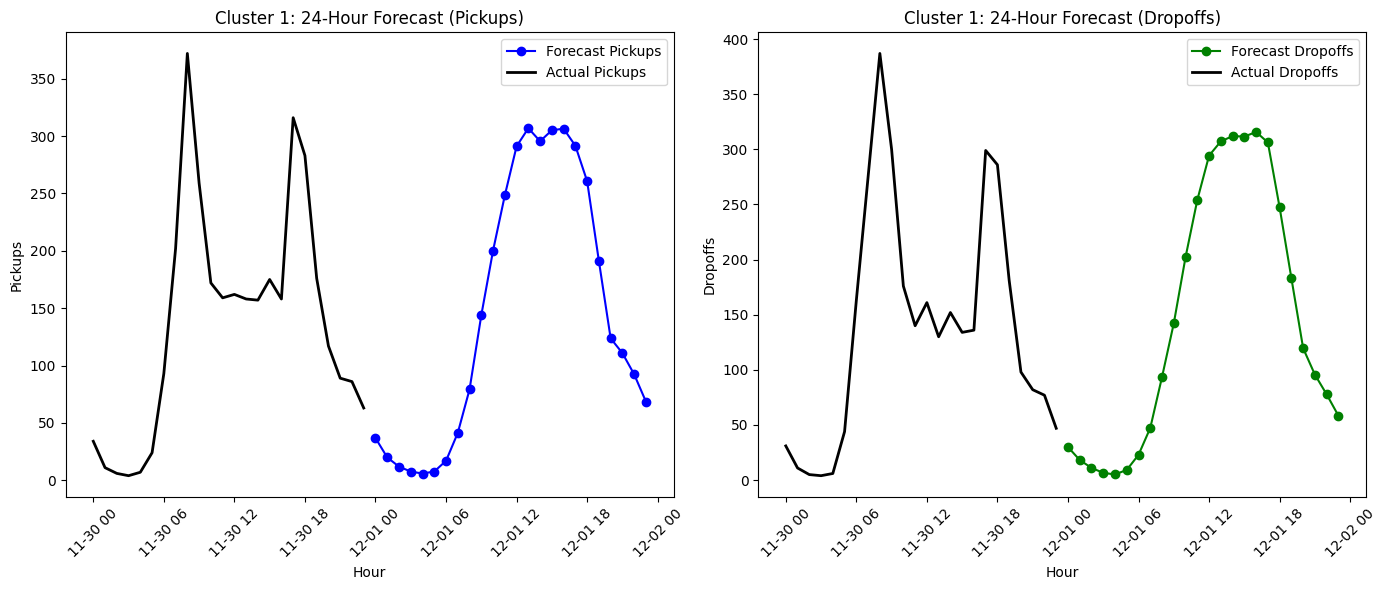

In [ ]:
def plot_24h_forecast(cluster_id, forecast_df, actual_df=None):
    """
    forecast_df: output of your 24-hour forecasting function
    actual_df: actual pickups/dropoffs for that day (optional)
    """

    df_fc = forecast_df[forecast_df["cluster"] == cluster_id].copy()

    plt.figure(figsize=(14,6))

    # --- Pickups ---
    plt.subplot(1,2,1)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_pickups"],
             label="Forecast Pickups", color='blue', marker='o')

    if actual_df is not None:
        df_actual = actual_df[actual_df["cluster"] == cluster_id]
        plt.plot(df_actual["hour"], df_actual["pickups"],
                 label="Actual Pickups", color='black', linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24-Hour Forecast (Pickups)")
    plt.xlabel("Hour")
    plt.ylabel("Pickups")
    plt.xticks(rotation=45)
    plt.legend()

    # --- Dropoffs ---
    plt.subplot(1,2,2)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_dropoffs"],
             label="Forecast Dropoffs", color='green', marker='o')

    if actual_df is not None:
        plt.plot(df_actual["hour"], df_actual["dropoffs"],
                 label="Actual Dropoffs", color='black', linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24-Hour Forecast (Dropoffs)")
    plt.xlabel("Hour")
    plt.ylabel("Dropoffs")
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_24h_forecast(cluster_id=1, 
                  forecast_df=final_forecasts,
                  actual_df=val[val["hour"].dt.date == val["hour"].dt.date.max()])

Actual rows: 24 Forecast rows: 24


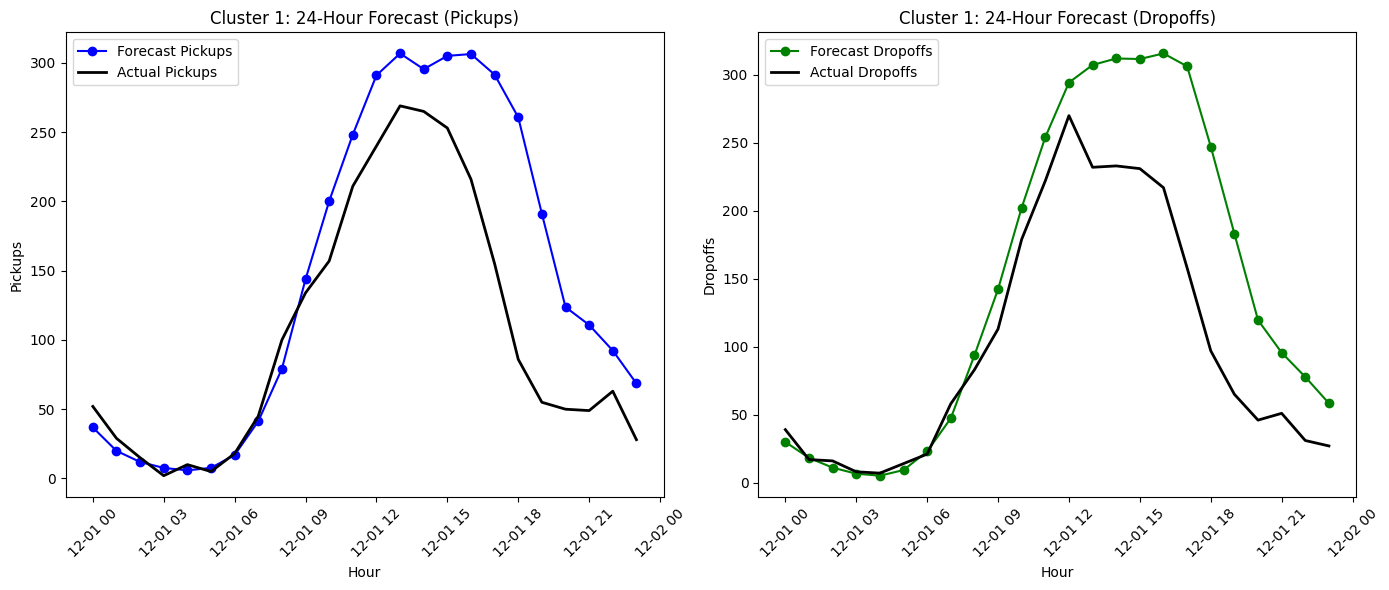

In [ ]:

cluster_id = 1                 # choose the cluster you want
target_date = pd.to_datetime("2018-12-01").date()

# 1) real dec1 stats
actual_dec1 = test[
    (test["cluster"] == cluster_id) &
    (test["hour"].dt.date == target_date)
].copy()

# 2) forecast dec1 stats
forecast_dec1 = final_forecasts[
    (final_forecasts["cluster"] == cluster_id) &
    (final_forecasts["forecast_hour"].dt.date == target_date)
].copy()

print("Actual rows:", len(actual_dec1), "Forecast rows:", len(forecast_dec1))

plot_24h_forecast(
    cluster_id=cluster_id,
    forecast_df=forecast_dec1,
    actual_df=actual_dec1,
)


In [ ]:
# Merge hourly weather into cluster time series

cluster_ts = cluster_ts.merge(
    weather_hourly[[
        "hour",
        "temp_celsius",
        "is_dry",
        "wind_kmh",
        "cycling_score"
    ]],
    on="hour",
    how="left"
)

print(cluster_ts.head())
print("Columns in cluster_ts:", cluster_ts.columns)


   cluster                hour  pickups  dropoffs  hour_of_day  day_of_week  \
0      0.0 2018-01-01 00:00:00        3         2            0            0   
1      0.0 2018-01-01 01:00:00        2         3            1            0   
2      0.0 2018-01-01 02:00:00        2         2            2            0   
3      0.0 2018-01-01 03:00:00        4         6            3            0   
4      0.0 2018-01-01 04:00:00        0         0            4            0   

   month  day  temp_celsius  is_dry   wind_kmh  cycling_score  
0      1    1    -13.678261       1  58.946083      30.000475  
1      1    1    -13.839129       1  58.930435      30.000425  
2      1    1    -14.060869       1  56.864346      30.000366  
3      1    1    -14.273912       1  55.205212      30.000317  
4      1    1    -14.456522       1  57.584347      30.000278  
Columns in cluster_ts: Index(['cluster', 'hour', 'pickups', 'dropoffs', 'hour_of_day', 'day_of_week',
       'month', 'day', 'temp_celsius', 

In [ ]:
# Train: Jan–Oct
train = cluster_ts[cluster_ts["month"] <= 10].reset_index(drop=True)

# Validation: Nov
val = cluster_ts[cluster_ts["month"] == 11].reset_index(drop=True)

# Test: Dec
test = cluster_ts[cluster_ts["month"] == 12].reset_index(drop=True)

print("Train rows:", len(train))
print("Validation rows:", len(val))
print("Test rows:", len(test))


Train rows: 182400
Validation rows: 18000
Test rows: 18600


In [ ]:
# add lag  per cluster

for df_ in (train, val, test):
    df_.sort_values(["cluster", "hour"], inplace=True)

    df_["lag1_pu"] = df_.groupby("cluster")["pickups"].shift(1)
    df_["lag1_do"] = df_.groupby("cluster")["dropoffs"].shift(1)
    df_.fillna(0, inplace=True)

print(train[["cluster", "hour", "pickups", "dropoffs", "lag1_pu", "lag1_do"]].head())


   cluster                hour  pickups  dropoffs  lag1_pu  lag1_do
0      0.0 2018-01-01 00:00:00        3         2      0.0      0.0
1      0.0 2018-01-01 01:00:00        2         3      3.0      2.0
2      0.0 2018-01-01 02:00:00        2         2      2.0      3.0
3      0.0 2018-01-01 03:00:00        4         6      2.0      2.0
4      0.0 2018-01-01 04:00:00        0         0      4.0      6.0


In [ ]:
from xgboost import XGBRegressor

feature_cols = [
    "cluster",
    "hour_of_day",
    "day_of_week",
    "month",
    "temp_celsius",
    "is_dry",
    "wind_kmh",
    "cycling_score",
    "lag1_pu",
    "lag1_do",
]

X_train = train[feature_cols]
X_val   = val[feature_cols]

# Pickups model
xgb_pu = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_pu.fit(
    X_train, train["pickups"],
    eval_set=[(X_val, val["pickups"])],
    verbose=False
)

# Dropoffs model
xgb_do = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_do.fit(
    X_train, train["dropoffs"],
    eval_set=[(X_val, val["dropoffs"])],
    verbose=False
)

# Predictions on validation
val["pred_pickups"]  = xgb_pu.predict(X_val)
val["pred_dropoffs"] = xgb_do.predict(X_val)

mae_pu_xgb  = mean_absolute_error(val["pickups"],  val["pred_pickups"])
rmse_pu_xgb = np.sqrt(mean_squared_error(val["pickups"],  val["pred_pickups"]))

mae_do_xgb  = mean_absolute_error(val["dropoffs"], val["pred_dropoffs"])
rmse_do_xgb = np.sqrt(mean_squared_error(val["dropoffs"], val["pred_dropoffs"]))

print("=== XGBOOST + WEATHER ===")
print("Pickups  - MAE:", mae_pu_xgb,  "RMSE:", rmse_pu_xgb)
print("Dropoffs - MAE:", mae_do_xgb,  "RMSE:", rmse_do_xgb)


=== XGBOOST + WEATHER ===
Pickups  - MAE: 10.339683532714844 RMSE: 20.766094538286367
Dropoffs - MAE: 10.390127182006836 RMSE: 20.97870319035064


In [ ]:
def plot_24h_forecast(cluster_id, forecast_df, actual_df=None):
    df_fc = forecast_df[forecast_df["cluster"] == cluster_id].copy()

    plt.figure(figsize=(14,6))

    # Pickups
    plt.subplot(1,2,1)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_pickups"],
             label="Forecast Pickups", marker="o")

    if actual_df is not None:
        df_actual = actual_df[actual_df["cluster"] == cluster_id]
        plt.plot(df_actual["hour"], df_actual["pickups"],
                 label="Actual Pickups", color="black", linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24h Forecast (Pickups)")
    plt.xticks(rotation=45)
    plt.xlabel("Hour")
    plt.ylabel("Pickups")
    plt.legend()

    # Dropoffs
    plt.subplot(1,2,2)
    plt.plot(df_fc["forecast_hour"], df_fc["pred_dropoffs"],
             label="Forecast Dropoffs", marker="o", color="green")

    if actual_df is not None:
        plt.plot(df_actual["hour"], df_actual["dropoffs"],
                 label="Actual Dropoffs", color="black", linewidth=2)

    plt.title(f"Cluster {cluster_id}: 24h Forecast (Dropoffs)")
    plt.xticks(rotation=45)
    plt.xlabel("Hour")
    plt.ylabel("Dropoffs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# 24h forecast with weather

feature_cols = [
    "cluster",
    "hour_of_day",
    "day_of_week",
    "month",
    "temp_celsius",
    "is_dry",
    "wind_kmh",
    "cycling_score",
    "lag1_pu",
    "lag1_do",
]

def forecast_next_24h_with_weather(cluster_id, cluster_ts, weather_hourly, xgb_pu, xgb_do):
    """
    24-hour ahead forecast for one cluster using the weather-trained XGBoost models.
    Uses REALIZED weather for those 24 hours (good enough for our explanatory report).
    """

    # last available row for that cluster 
    last_row = (
        cluster_ts[cluster_ts["cluster"] == cluster_id]
        .sort_values("hour")
        .iloc[-1]
    )

    lag_pu = last_row["pickups"]
    lag_do = last_row["dropoffs"]

    next_day_start = last_row["hour"].replace(hour=0) + pd.Timedelta(days=1)

    forecasts = []

    for h in range(24):
        current_hour = next_day_start + pd.Timedelta(hours=h)

        # get weather for that hour
        w = weather_hourly[weather_hourly["hour"] == current_hour]
        if w.empty:
            # fallback if missing (shouldn't usually happen)
            w = weather_hourly.iloc[[-1]]

        temp_c = w["temp_celsius"].values[0]
        is_dry = w["is_dry"].values[0]
        wind_k = w["wind_kmh"].values[0]
        cycl   = w["cycling_score"].values[0]

        X = pd.DataFrame({
            "cluster":      [cluster_id],
            "hour_of_day":  [current_hour.hour],
            "day_of_week":  [current_hour.dayofweek],
            "month":        [current_hour.month],
            "temp_celsius": [temp_c],
            "is_dry":       [is_dry],
            "wind_kmh":     [wind_k],
            "cycling_score":[cycl],
            "lag1_pu":      [lag_pu],
            "lag1_do":      [lag_do],
        })

        pred_pu = xgb_pu.predict(X)[0]
        pred_do = xgb_do.predict(X)[0]

        forecasts.append({
            "cluster":       cluster_id,
            "forecast_hour": current_hour,
            "pred_pickups":  pred_pu,
            "pred_dropoffs": pred_do
        })

        lag_pu = pred_pu
        lag_do = pred_do

    return pd.DataFrame(forecasts)


In [ ]:
# Take last available date from train + val
last_available_date = val["hour"].dt.date.max()
last_day_all_clusters = cluster_ts[cluster_ts["hour"].dt.date == last_available_date]

clusters = sorted(cluster_ts["cluster"].unique())
forecasts_weather = []

for cid in clusters:
    df_fc = forecast_next_24h_with_weather(
        cluster_id    = cid,
        cluster_ts    = last_day_all_clusters,
        weather_hourly= weather_hourly,
        xgb_pu        = xgb_pu,
        xgb_do        = xgb_do,
    )
    forecasts_weather.append(df_fc)

final_forecasts_weather = pd.concat(forecasts_weather, ignore_index=True)
final_forecasts_weather.head()


cluster       forecast_hour  pred_pickups  pred_dropoffs
0      0.0 2018-12-01 00:00:00      9.108639      13.170020
1      0.0 2018-12-01 01:00:00      5.141262       7.825965
2      0.0 2018-12-01 02:00:00      2.574390       3.936040
3      0.0 2018-12-01 03:00:00      0.827860       1.388927
4      0.0 2018-12-01 04:00:00      0.600523       0.303803

Actual rows: 24 Forecast rows (weather model): 24


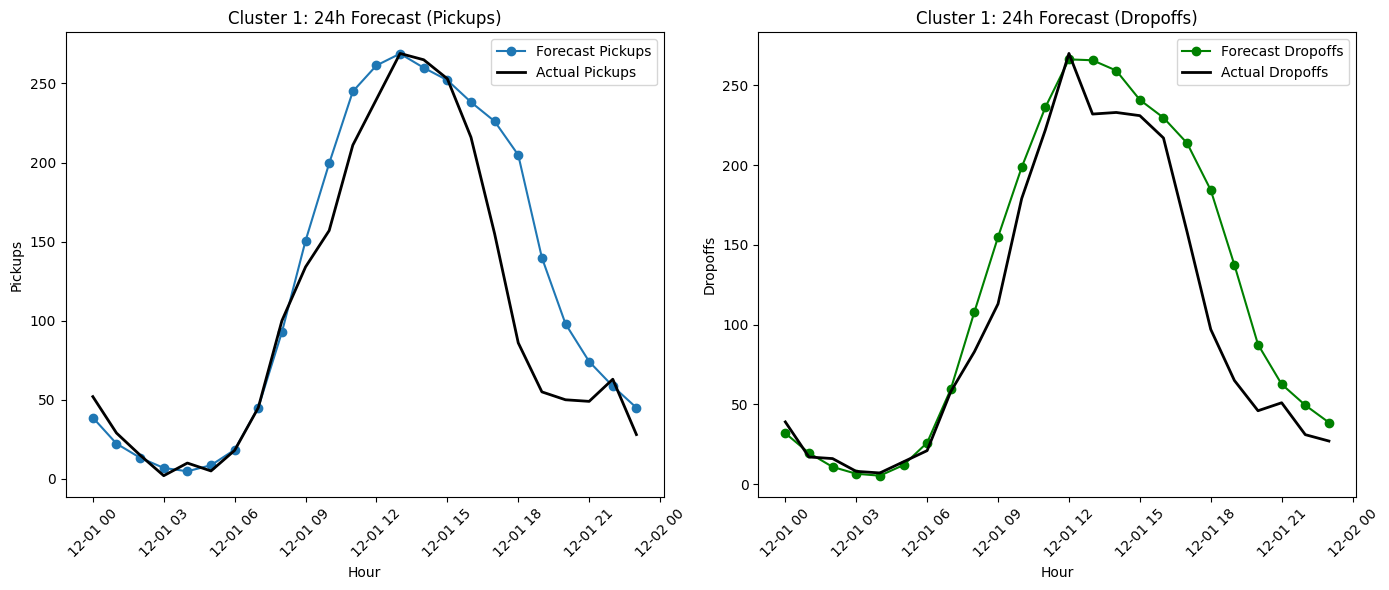

In [ ]:
cluster_id  = 1
target_date = pd.to_datetime("2018-12-01").date()

actual_dec1 = test[
    (test["cluster"] == cluster_id) &
    (test["hour"].dt.date == target_date)
].copy()

forecast_dec1_weather = final_forecasts_weather[
    (final_forecasts_weather["cluster"] == cluster_id) &
    (final_forecasts_weather["forecast_hour"].dt.date == target_date)
].copy()

print("Actual rows:", len(actual_dec1), "Forecast rows (weather model):", len(forecast_dec1_weather))

plot_24h_forecast(
    cluster_id = cluster_id,
    forecast_df= forecast_dec1_weather,
    actual_df  = actual_dec1,
)


In [ ]:
#no weather from the xgboost
mae_pu_no_w  = mae_pu
rmse_pu_no_w = rmse_pu
mae_do_no_w  = mae_do
rmse_do_no_w = rmse_do

#weather
mae_pu_w  = mae_pu_xgb
rmse_pu_w = rmse_pu_xgb
mae_do_w  = mae_do_xgb
rmse_do_w = rmse_do_xgb

results = pd.DataFrame({
    "Metric": ["MAE (Pickups)", "RMSE (Pickups)", "MAE (Dropoffs)", "RMSE (Dropoffs)"],
    "No Weather": [mae_pu_no_w, rmse_pu_no_w, mae_do_no_w, rmse_do_no_w],
    "With Weather": [mae_pu_w, rmse_pu_w, mae_do_w, rmse_do_w]
})

results["Improvement"] = results["No Weather"] - results["With Weather"]
results["Improvement (%)"] = 100 * results["Improvement"] / results["No Weather"]

styled = (
    results.style
        .format({
            "No Weather": "{:.3f}",
            "With Weather": "{:.3f}",
            "Improvement": "{:.3f}",
            "Improvement (%)": "{:.2f}%"
        })
        .set_caption("Comparison of XGBoost Performance With and Without Weather Features")
)

styled


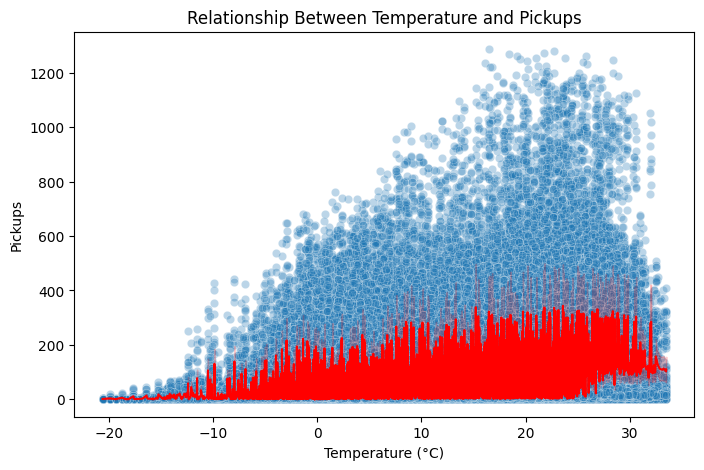

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=cluster_ts["temp_celsius"], 
    y=cluster_ts["pickups"], alpha=0.3
)
sns.lineplot(
    x=cluster_ts["temp_celsius"],
    y=cluster_ts["pickups"],
    estimator="mean",
    color="red"
)
plt.title("Relationship Between Temperature and Pickups")
plt.xlabel("Temperature (°C)")
plt.ylabel("Pickups")
plt.show()

